Trying to fit the function of https://arxiv.org/pdf/1010.1005.pdf

In [1]:
import numpy as np
import pandas as pd

from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
train = pd.read_csv('../input/training_set.csv')
train_meta = pd.read_csv('../input/training_set_metadata.csv')
train = train.merge(train_meta[['object_id', 'target']], how='left', on='object_id')

In [3]:
def curve(t, A, phi, k, sigma):
    res = A * ((t - phi) / sigma)**k * np.exp(-(t - phi) / sigma) * np.exp(k) / k**k
    res = np.where(t <= phi, 0, res)
    return res

In [10]:
def plot_newling(object_id, passbands=range(6), expand=False):
    print('object_id = ', object_id)
    _passbands = ['C4','C2','C3','C1', 'k','C5']
    df = train[(train.object_id == object_id)]
    offset = 11
    t0s = []
    trises = []
    p0s = []
    bmins = []
    bmaxs = []
    xs = []
    ys = []
    y_errs = []
    mcovs = []
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    for pb in passbands:
        if 1:
            df = train[(train.object_id == object_id) & (train.passband == pb)]
            mjd_delta_prev = (df.mjd - df.mjd.shift(1)).fillna(100).values.ravel()
            mjd_delta_next = (df.mjd.shift(-1) - df.mjd).fillna(100).values.ravel()
            x_min = df.mjd.min()
            x_max = df.mjd.max()
            y_err_mean = df.flux_err.mean()
            x = df.mjd.values
            y = df.flux.values
            y_err = df.flux_err
            if expand:
                mjd_delta_prev = np.concatenate((100 * np.ones((offset,)),
                                    mjd_delta_prev,
                                    100 * np.ones((offset,)),
                                  ))
                mjd_delta_next = np.concatenate((100 * np.ones((offset,)),
                                    mjd_delta_next,
                                    100 * np.ones((offset,)),
                                  ))
                x = np.concatenate((np.linspace(x_min-250, x_min -200, offset),
                                    x,
                                    np.linspace(x_max+200, x_max+250, offset),
                                  ))
                y = np.concatenate((np.random.randn(offset) * yerr_mean,
                                    y,
                                    np.random.randn(offset) * yerr_mean
                                   ))
                y_err = np.concatenate((y_err_mean * np.ones(offset),
                                        y_err,
                                        y_err_mean * np.ones(offset)
                                      ))
            ax.scatter(x, y, c=_passbands[pb], marker='+')
            idxmax = np.argmax(y)
            t00 = x[np.argmax(y)]
            print(t00, idxmax, y[idxmax], mjd_delta_prev[idxmax])
            A = y.max() 
            Amin = A
            Amax = 2*A
            phi = -5
            k = 0.5
            sigma = 10
            if mjd_delta_prev[idxmax] > 50:
                print('gap before')
                phi = -50
                Amin = 1.5*A
                Amax = 4*A
            tmax = 20
            if mjd_delta_next[idxmax] > 50:
                print('gap after')
                Amin = 1.5*A
                Amax = 4*A
            
            
            p0 = [(Amin + Amax) / 2, t00 + phi, k, sigma]
            bmin = [Amin, t00 + phi -50, k/10, sigma/10]
            bmax =[Amax, t00, k*10, sigma*10]
            bounds = (bmin, bmax)
            print(p0)
            print(bmin)
            print(bmax)

            def test_func(t, A, phi, k, sigma): 
                res = curve(t, A, phi, k, sigma)
                return res

            params, params_covariance = curve_fit(test_func, x, y, p0, y_err, 
                                                  bounds=bounds,
                                                  max_nfev=1000)

            print('result:', end=' ')
            for p in params:
                print('%0.2f' % p, end=' ')
            
            median_cov = np.abs(np.median(params_covariance / A))
            print('median cov: %.0f' % median_cov)
            
            linestyle = '-'
            if median_cov > 1000:
                linestyle = '--'
            elif pb in range(1, 5):
                t0s.append(params[1])
            p0s.append([params[0], params[2], params[3]])
            bmins.append([bmin[0], bmin[2], bmin[3]])
            bmaxs.append([bmax[0], bmax[2], bmax[3]])
            xs.append(x)
            ys.append(y)
            y_errs.append(y_err)
            mcovs.append(median_cov)
            t = np.linspace(x.min(), x.max(), 1000)
            ax.plot(t, test_func(t, *params), c=_passbands[pb], linestyle=linestyle)
        else:
            continue
    plt.show()
    print(t0s)
    phi = np.median(t0s)
    t0s = [t for t in t0s if np.abs(t - phi) < 50]
    if len(t0s) <= 1 and len(passbands) > 1:
        return
    phi = (np.min(t0s) + np.median(t0s)) / 2
    print(t0s)
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    print('phi', phi)
    for pb, p0, bmin, bmax, x, y, y_err, median_cov in zip(range(0,6), p0s, bmins, bmaxs, xs, ys, y_errs, mcovs):
        if True:
            ax.scatter(x, y, c=_passbands[pb], marker='+')
            bounds = (bmin, bmax)

            def test_func(t, A, k, sigma): 
                res = curve(t, A, phi, k, sigma)
                return res

            params, params_covariance = curve_fit(test_func, x, y, p0, y_err, 
                                                  bounds=bounds,
                                                  max_nfev=1000)

            for p in params:
                print('%0.2f' % p, end=' ')
            
            median_cov = np.median(params_covariance / A)
            print('median cov: %.0f' % median_cov)
            
            linestyle = '-'
            if median_cov > 1000:
                linestyle = '--'
            else:
                True
            t = np.linspace(x.min(), x.max(), 1000)
            ax.plot(t, test_func(t, *params), c=_passbands[pb], linestyle=linestyle)
        else:
            continue
    plt.show()
    

In [11]:
def curve_elt(t, A, phi, k, sigma):
    if t <= phi:
        return 0
    res = A * ((t - phi) / sigma)**k * np.exp(-(t - phi) / sigma) * np.exp(k) / k**k
    return res

object_id =  4173
59968.1942 10 199.27574199999998 264.12749999999505
gap before
[548.0082904999999, 59918.1942, 0.5, 10]
[298.91361299999994, 59868.1942, 0.05, 1.0]
[797.1029679999999, 59968.1942, 5.0, 100]
result: 736.85 59868.20 0.34 43.23 median cov: 1
59947.3396 14 244.89581299999998 253.33920000000217
gap before
[673.4634857499999, 59897.3396, 0.5, 10]
[367.34371949999996, 59847.3396, 0.05, 1.0]
[979.5832519999999, 59947.3396, 5.0, 100]
result: 367.34 59903.45 0.32 39.91 median cov: 0
59947.332 14 193.026001 253.33929999999964
gap before
[530.82150275, 59897.332, 0.5, 10]
[289.53900150000004, 59847.332, 0.05, 1.0]
[772.104004, 59947.332, 5.0, 100]


/home/jfpuget/anaconda3/envs/tf110/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/home/jfpuget/anaconda3/envs/tf110/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app


result: 289.54 59897.85 0.49 35.90 median cov: 0
59947.3472 14 160.237259 253.3391999999949
gap before
[440.65246225, 59897.3472, 0.5, 10]
[240.3558885, 59847.3472, 0.05, 1.0]
[640.949036, 59947.3472, 5.0, 100]
result: 240.37 59903.51 0.36 36.84 median cov: 0
59947.3582 14 129.679779 253.33929999999964
gap before
[356.61939225, 59897.3582, 0.5, 10]
[194.5196685, 59847.3582, 0.05, 1.0]
[518.719116, 59947.3582, 5.0, 100]
result: 194.52 59882.93 1.01 29.78 median cov: 0
59957.3257 15 91.792503 9.960500000001048
[137.6887545, 59952.3257, 0.5, 10]
[91.792503, 59902.3257, 0.05, 1.0]
[183.585006, 59957.3257, 5.0, 100]
result: 99.25 59947.37 0.05 42.52 median cov: 0


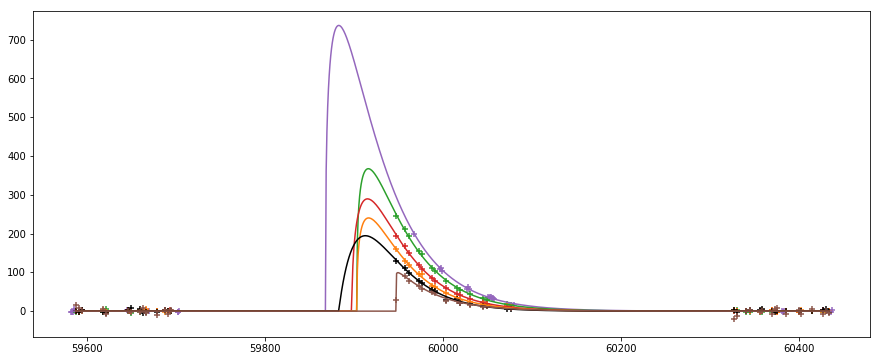

[59903.44630316916, 59897.8500583584, 59903.51157162606, 59882.93068220121]
[59903.44630316916, 59897.8500583584, 59903.51157162606, 59882.93068220121]
phi 59891.789431482495
565.65 0.22 44.25 median cov: 0
394.19 0.46 38.42 median cov: 0
293.87 0.61 34.76 median cov: 0
264.04 0.49 35.72 median cov: 0
194.52 0.74 31.60 median cov: 0
183.59 0.40 38.37 median cov: 0


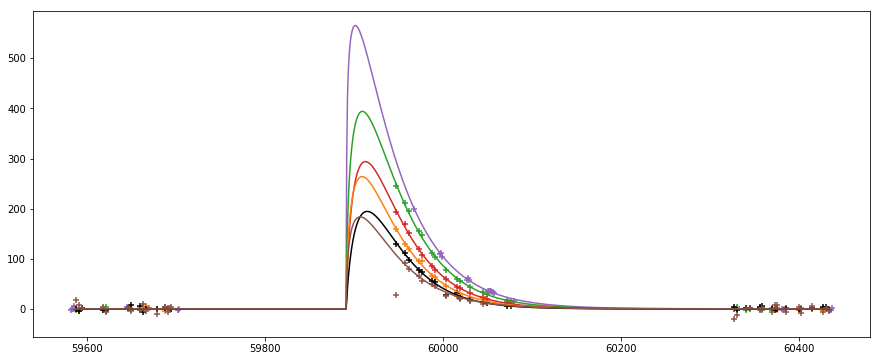

In [12]:
object_id = 4173

plot_newling(object_id, range(6))

class 15
class 15 object_id =  4173
59968.1942 21 199.27574199999998 264.12749999999505
gap before
[548.0082904999999, 59918.1942, 0.5, 10]
[298.91361299999994, 59868.1942, 0.05, 1.0]
[797.1029679999999, 59968.1942, 5.0, 100]
result: 736.85 59868.20 0.34 43.23 median cov: 1
59947.3396 25 244.89581299999998 253.33920000000217
gap before
[673.4634857499999, 59897.3396, 0.5, 10]
[367.34371949999996, 59847.3396, 0.05, 1.0]
[979.5832519999999, 59947.3396, 5.0, 100]
result: 367.34 59903.45 0.32 39.91 median cov: 0
59947.332 25 193.026001 253.33929999999964
gap before
[530.82150275, 59897.332, 0.5, 10]
[289.53900150000004, 59847.332, 0.05, 1.0]
[772.104004, 59947.332, 5.0, 100]
result: 289.54 59897.85 0.49 35.90 median cov: 0


/home/jfpuget/anaconda3/envs/tf110/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in sqrt
/home/jfpuget/anaconda3/envs/tf110/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in power


59947.3472 25 160.237259 253.3391999999949
gap before
[440.65246225, 59897.3472, 0.5, 10]
[240.3558885, 59847.3472, 0.05, 1.0]
[640.949036, 59947.3472, 5.0, 100]
result: 240.37 59903.51 0.36 36.84 median cov: 0
59947.3582 25 129.679779 253.33929999999964
gap before
[356.61939225, 59897.3582, 0.5, 10]
[194.5196685, 59847.3582, 0.05, 1.0]
[518.719116, 59947.3582, 5.0, 100]
result: 194.52 59882.93 1.01 29.78 median cov: 0
59957.3257 26 91.792503 9.960500000001048
[137.6887545, 59952.3257, 0.5, 10]
[91.792503, 59902.3257, 0.05, 1.0]
[183.585006, 59957.3257, 5.0, 100]
result: 99.25 59947.37 0.05 42.52 median cov: 0


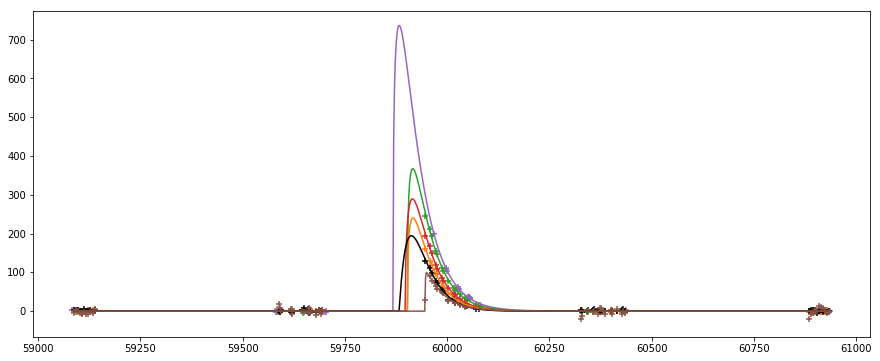

[59903.446301052616, 59897.850062288184, 59903.511559865845, 59882.930731374734]
[59903.446301052616, 59897.850062288184, 59903.511559865845, 59882.930731374734]
phi 59891.78945652257
565.65 0.22 44.25 median cov: 0
394.19 0.46 38.42 median cov: 0
293.87 0.61 34.76 median cov: 0
264.04 0.49 35.72 median cov: 0
194.52 0.74 31.60 median cov: 0
183.59 0.40 38.37 median cov: 0


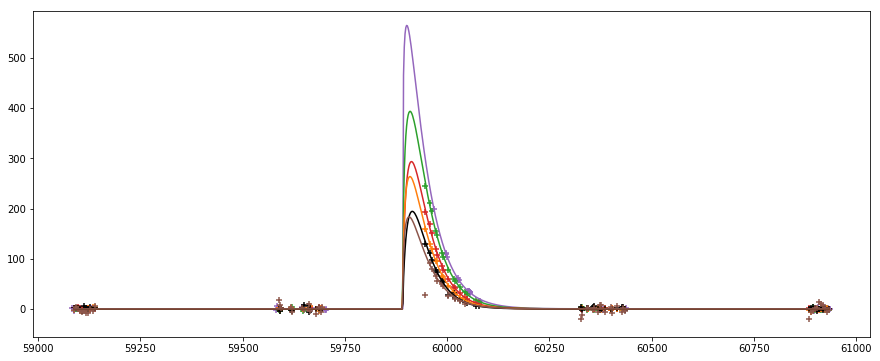

class 15 object_id =  23116
59939.0808 30 46.084736 1.0054000000018277
gap after
[126.733024, 59934.0808, 0.5, 10]
[69.127104, 59884.0808, 0.05, 1.0]
[184.338944, 59939.0808, 5.0, 100]
result: 69.13 59884.08 2.95 33.60 median cov: 0
59945.0846 31 61.381195 2.9956999999994878
gap after
[168.79828625, 59940.0846, 0.5, 10]
[92.0717925, 59890.0846, 0.05, 1.0]
[245.52478, 59945.0846, 5.0, 100]
result: 92.07 59890.08 2.81 33.18 median cov: 0
59945.077 31 53.841301 3.0023999999975786
gap after
[148.06357775, 59940.077, 0.5, 10]
[80.76195150000001, 59890.077, 0.05, 1.0]
[215.365204, 59945.077, 5.0, 100]
result: 80.76 59890.08 2.75 33.21 median cov: 0
59945.0922 31 49.198547 2.9956999999994878
gap after
[135.29600425, 59940.0922, 0.5, 10]
[73.7978205, 59890.0922, 0.05, 1.0]
[196.794188, 59945.0922, 5.0, 100]
result: 73.80 59890.09 2.94 31.73 median cov: 0
59945.1032 31 43.066681 2.9957999999969616
gap after
[118.43337275, 59940.1032, 0.5, 10]
[64.6000215, 59890.1032, 0.05, 1.0]
[172.266724, 599

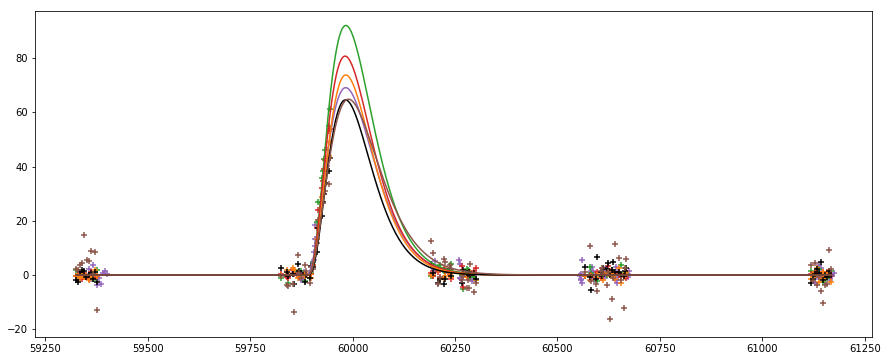

[59890.08460000001, 59890.077000000005, 59890.09220000001, 59890.103200000005]
[59890.08460000001, 59890.077000000005, 59890.09220000001, 59890.103200000005]
phi 59890.082700000006
69.13 2.51 36.84 median cov: 0
92.07 2.81 33.18 median cov: 0
80.76 2.75 33.21 median cov: 0
73.80 2.94 31.72 median cov: 0
64.60 2.98 31.01 median cov: 0
64.87 2.58 38.77 median cov: 0


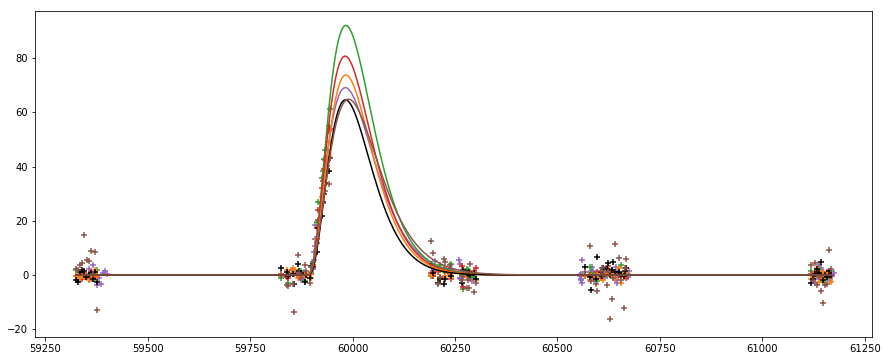

class 15 object_id =  97406
59819.1532 11 31.868305 100.0
gap before
[87.63783875, 59769.1532, 0.5, 10]
[47.8024575, 59719.1532, 0.05, 1.0]
[127.47322, 59819.1532, 5.0, 100]
result: 85.45 59719.15 0.81 35.19 median cov: 773
59750.4306 11 121.80761000000001 100.0
gap before
[334.9709275, 59700.4306, 0.5, 10]
[182.71141500000002, 59650.4306, 0.05, 1.0]
[487.23044000000004, 59750.4306, 5.0, 100]
result: 487.23 59686.42 0.05 38.63 median cov: 0
59750.4229 11 82.106247 100.0
gap before
[225.79217925, 59700.4229, 0.5, 10]
[123.1593705, 59650.4229, 0.05, 1.0]
[328.424988, 59750.4229, 5.0, 100]
result: 328.42 59691.82 0.05 36.16 median cov: 0
59752.4224 12 59.68713399999999 1.9841000000014901
[89.530701, 59747.4224, 0.5, 10]
[59.68713399999999, 59697.4224, 0.05, 1.0]
[119.37426799999999, 59752.4224, 5.0, 100]
result: 119.37 59717.92 0.05 36.70 median cov: 0
59750.445 11 51.492214000000004 100.0
gap before
[141.6035885, 59700.445, 0.5, 10]
[77.23832100000001, 59650.445, 0.05, 1.0]
[205.96885600

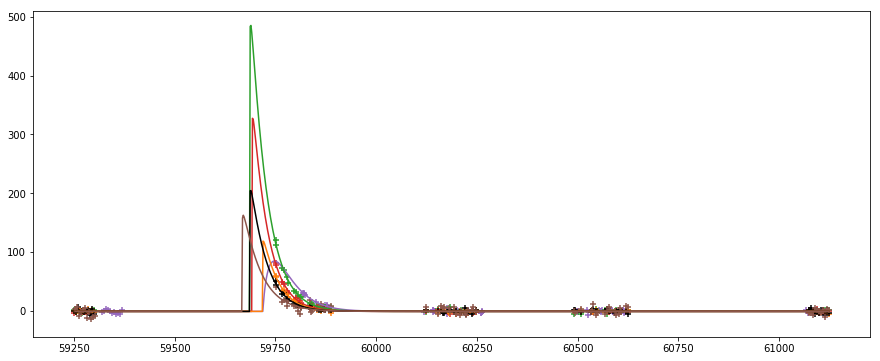

[59686.421821902215, 59691.81706306207, 59717.92417430059, 59686.46078089195]
[59686.421821902215, 59691.81706306207, 59717.92417430059, 59686.46078089195]
phi 59687.78037193962
105.40 1.29 33.15 median cov: 1
471.59 0.05 38.60 median cov: 0
328.42 0.09 35.82 median cov: 0
119.37 0.60 30.55 median cov: 0
199.37 0.05 37.73 median cov: 0
104.91 0.05 41.65 median cov: 0


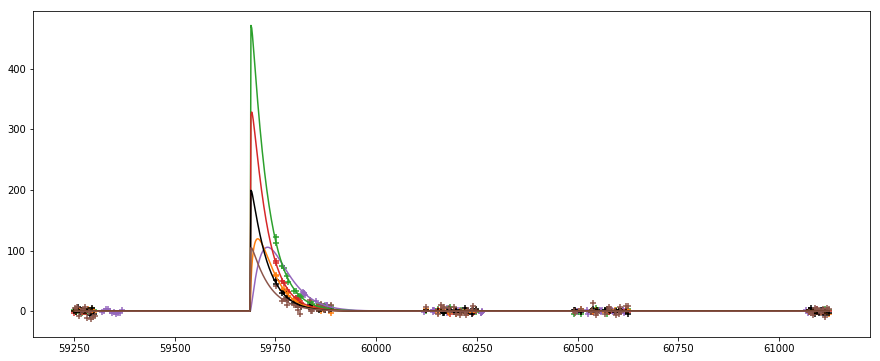

class 15 object_id =  113669
59851.1114 16 155.005539 27.96089999999822
[232.5083085, 59846.1114, 0.5, 10]
[155.005539, 59796.1114, 0.05, 1.0]
[310.011078, 59851.1114, 5.0, 100]
result: 197.64 59851.10 0.05 53.54 median cov: 0
59857.0531 26 139.615845 2.9657999999981257
[209.4237675, 59852.0531, 0.5, 10]
[139.615845, 59802.0531, 0.05, 1.0]
[279.23169, 59857.0531, 5.0, 100]
result: 139.62 59809.35 2.98 17.43 median cov: 0
59864.0162 27 108.175873 6.970900000000256
[162.26380949999998, 59859.0162, 0.5, 10]
[108.175873, 59809.0162, 0.05, 1.0]
[216.351746, 59864.0162, 5.0, 100]
result: 108.38 59844.88 0.41 38.39 median cov: 4
59870.0349 29 83.81414000000001 3.00170000000071
[125.72121000000001, 59865.0349, 0.5, 10]
[83.81414000000001, 59815.0349, 0.05, 1.0]
[167.62828000000002, 59870.0349, 5.0, 100]
result: 84.50 59866.20 0.05 50.23 median cov: 6
59867.0443 28 71.26750899999999 3.0014999999984866
[106.90126349999998, 59862.0443, 0.5, 10]
[71.26750899999999, 59812.0443, 0.05, 1.0]
[142.5350

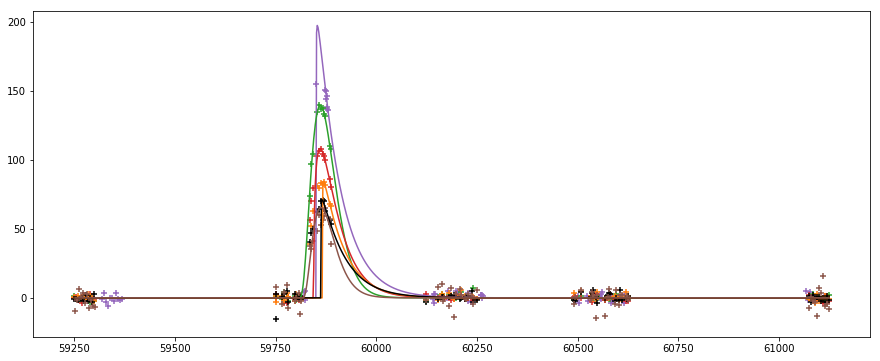

[59809.35046184158, 59844.87833434388, 59866.202533610594, 59862.09672466977]
[59809.35046184158, 59844.87833434388, 59866.202533610594, 59862.09672466977]
phi 59831.418995674205
171.02 1.47 19.75 median cov: 0
139.62 0.70 39.24 median cov: 0
108.18 0.75 36.28 median cov: 0
83.81 0.75 38.70 median cov: 0
71.27 0.72 36.89 median cov: 0
65.53 0.89 31.61 median cov: 0


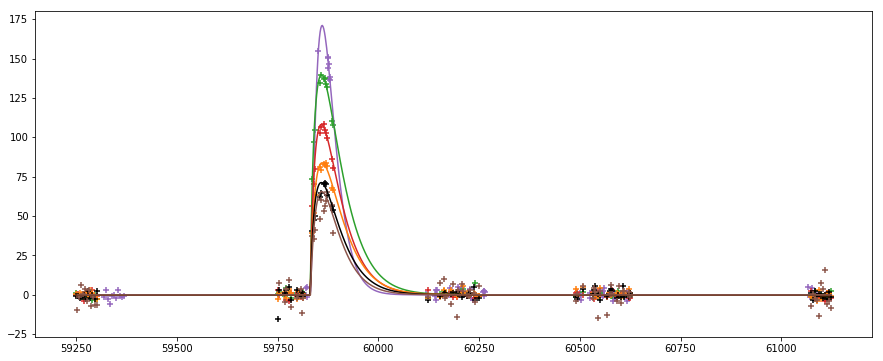

class 15 object_id =  133234
59968.1942 21 4.874873 264.12749999999505
gap before
[13.40590075, 59918.1942, 0.5, 10]
[7.3123095, 59868.1942, 0.05, 1.0]
[19.499492, 59968.1942, 5.0, 100]
result: 7.31 59922.77 0.30 45.43 median cov: 3099
59947.3396 25 10.523506 253.33920000000217
gap before
[28.9396415, 59897.3396, 0.5, 10]
[15.785259, 59847.3396, 0.05, 1.0]
[42.094024, 59947.3396, 5.0, 100]
result: 15.79 59860.32 5.00 12.06 median cov: 48
59947.332 25 8.756289 253.33929999999964
gap before
[24.07979475, 59897.332, 0.5, 10]
[13.1344335, 59847.332, 0.05, 1.0]
[35.025156, 59947.332, 5.0, 100]
result: 35.03 59893.26 0.05 31.66 median cov: 300
59947.3472 25 6.45411 253.3391999999949
gap before
[17.7488025, 59897.3472, 0.5, 10]
[9.681165, 59847.3472, 0.05, 1.0]
[25.81644, 59947.3472, 5.0, 100]
result: 25.82 59906.36 0.05 22.77 median cov: 2017
59947.3582 25 7.918692999999999 253.33929999999964
gap before
[21.77640575, 59897.3582, 0.5, 10]
[11.8780395, 59847.3582, 0.05, 1.0]
[31.67477199999999

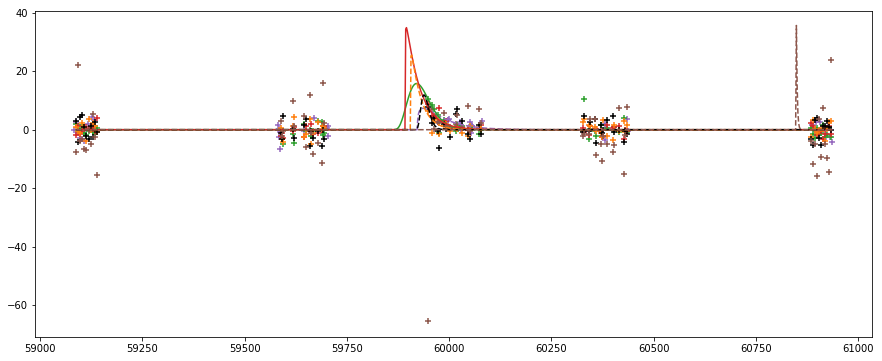

[59860.32411520573, 59893.25844250353]
[59860.32411520573, 59893.25844250353]
phi 59868.55769703018
11.01 0.75 42.24 median cov: 4
15.79 4.10 12.86 median cov: 1
35.03 0.45 28.60 median cov: 1
25.82 1.18 18.38 median cov: 20
31.67 5.00 7.78 median cov: 180
41.92 0.10 1.86 median cov: 0


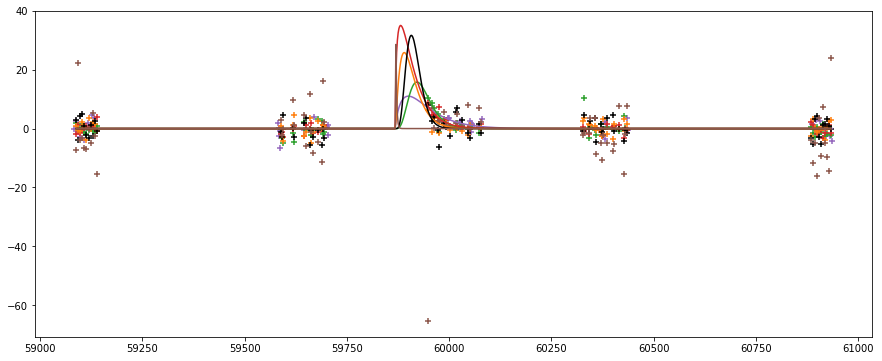

class 42
class 42 object_id =  730
59822.2433 15 5.942166 0.9955000000045402
[8.913249, 59817.2433, 0.5, 10]
[5.942166, 59767.2433, 0.05, 1.0]
[11.884332, 59822.2433, 5.0, 100]
result: 5.94 59819.66 2.58 3.26 median cov: 6
59857.1485 16 5.693109 2.9922000000005937
[8.5396635, 59852.1485, 0.5, 10]
[5.693109, 59802.1485, 0.05, 1.0]
[11.386218, 59857.1485, 5.0, 100]
result: 7.13 59854.16 0.22 6.00 median cov: 119
60532.3019 47 20.994711 245.19719999999506
gap before
[57.73545525, 60482.3019, 0.5, 10]
[31.4920665, 60432.3019, 0.05, 1.0]
[83.978844, 60532.3019, 5.0, 100]
result: 31.49 60432.30 2.34 26.22 median cov: 34
60538.298 49 33.572102 3.0023000000001048
[50.358153, 60533.298, 0.5, 10]
[33.572102, 60483.298, 0.05, 1.0]
[67.144204, 60538.298, 5.0, 100]
result: 33.90 60532.39 0.31 25.23 median cov: 0
60532.3282 46 41.159981 245.1973000000071
gap before
[113.18994775, 60482.3282, 0.5, 10]
[61.7399715, 60432.3282, 0.05, 1.0]
[164.639924, 60532.3282, 5.0, 100]
result: 61.74 60432.33 2.80 2

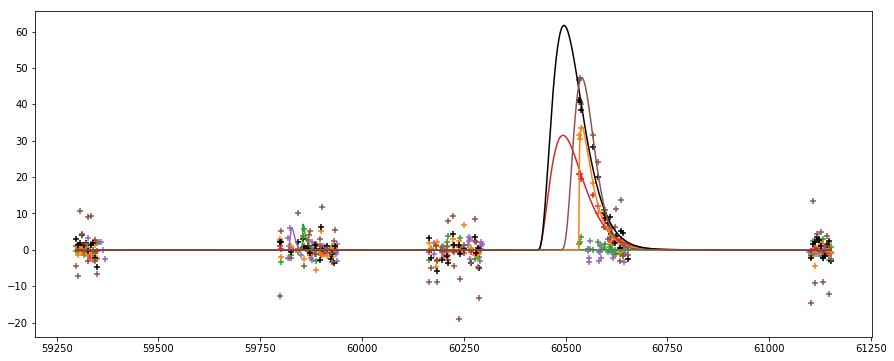

[59854.15642773976, 60432.30190001148, 60532.38781613389, 60432.328200148964]
[60432.30190001148, 60432.328200148964]
phi 60432.30847504585
5.94 2.58 3.26 median cov: 0
5.69 2.96 15.97 median cov: 85
31.49 2.34 26.22 median cov: 0
37.26 5.00 16.18 median cov: 0
61.74 2.80 22.82 median cov: 0
51.34 5.00 16.66 median cov: 1


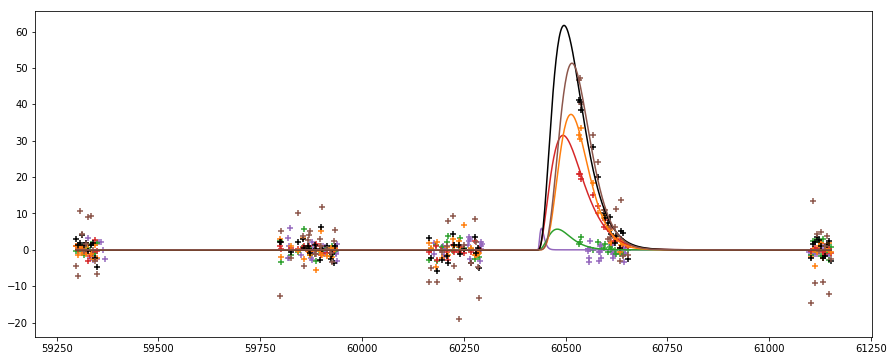

class 42 object_id =  1632
60199.0914 34 5.241472 0.983699999997043
[7.862208, 60194.0914, 0.5, 10]
[5.241472, 60144.0914, 0.05, 1.0]
[10.482944, 60199.0914, 5.0, 100]
result: 5.24 60192.99 2.43 1.00 median cov: 23343
59770.2256 14 5.108418 2.9210999999995693
[7.6626270000000005, 59765.2256, 0.5, 10]
[5.108418, 59715.2256, 0.05, 1.0]
[10.216836, 59770.2256, 5.0, 100]
result: 7.18 59768.05 1.08 1.00 median cov: 47919118455090032
59779.3188 15 4.109369 9.100899999997637
[6.1640535, 59774.3188, 0.5, 10]
[4.109369, 59724.3188, 0.05, 1.0]
[8.218738, 59779.3188, 5.0, 100]
result: 4.79 59770.22 0.10 9.76 median cov: 1
59750.4383 11 7.900053 100.0
gap before
[21.72514575, 59700.4383, 0.5, 10]
[11.8500795, 59650.4383, 0.05, 1.0]
[31.600212, 59750.4383, 5.0, 100]
result: 27.01 59650.44 0.05 57.02 median cov: 4811
59750.445 11 17.082548000000003 100.0
gap before
[46.97700700000001, 59700.445, 0.5, 10]
[25.623822000000004, 59650.445, 0.05, 1.0]
[68.33019200000001, 59750.445, 5.0, 100]
result: 25.6

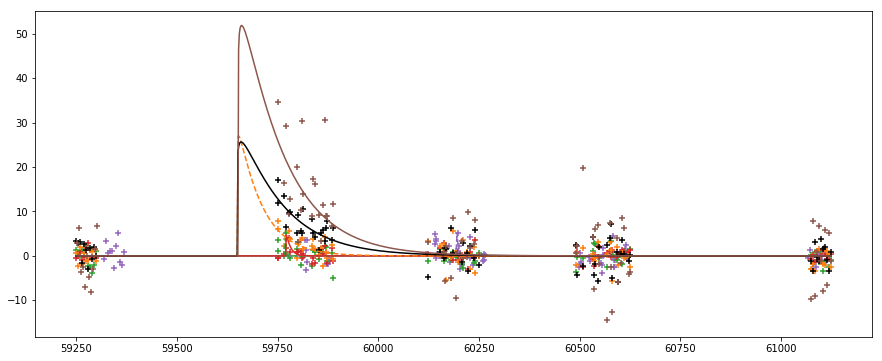

[59770.217865674334, 59650.44500000001]
class 42 object_id =  2103
60228.0187 40 98.29547099999999 20.871800000000803
[147.44320649999997, 60223.0187, 0.5, 10]
[98.29547099999999, 60173.0187, 0.05, 1.0]
[196.59094199999998, 60228.0187, 5.0, 100]
result: 110.62 60207.14 1.84 7.91 median cov: 0
60224.0217 45 214.805969 2.998699999996461
[322.2089535, 60219.0217, 0.5, 10]
[214.805969, 60169.0217, 0.05, 1.0]
[429.611938, 60224.0217, 5.0, 100]
result: 222.80 60220.94 0.10 15.46 median cov: 0
60224.014 45 134.434021 2.998700000003737
[201.6510315, 60219.014, 0.5, 10]
[134.434021, 60169.014, 0.05, 1.0]
[268.868042, 60224.014, 5.0, 100]
result: 136.09 60216.88 0.44 25.36 median cov: 0
60224.0294 45 127.249214 2.998599999998987
[190.873821, 60219.0294, 0.5, 10]
[127.249214, 60169.0294, 0.05, 1.0]
[254.498428, 60224.0294, 5.0, 100]
result: 127.25 60220.68 0.09 61.39 median cov: 0
60227.0416 46 138.748123 3.0010999999940395
[208.1221845, 60222.0416, 0.5, 10]
[138.748123, 60172.0416, 0.05, 1.0]
[2

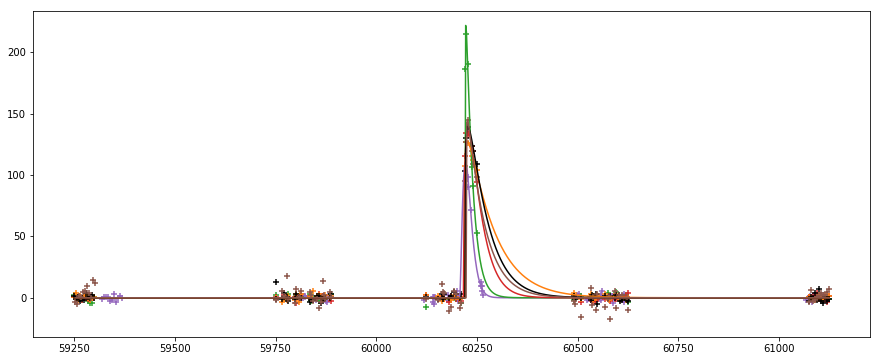

[60220.93530803638, 60216.88134729003, 60220.67652229945, 60220.48300423049]
[60220.93530803638, 60216.88134729003, 60220.67652229945, 60220.48300423049]
phi 60218.7305552775
101.86 0.66 9.63 median cov: 0
214.81 0.44 11.01 median cov: 0
136.24 0.28 30.47 median cov: 0
127.25 0.23 43.08 median cov: 0
138.75 0.36 29.93 median cov: 0
145.03 0.57 18.35 median cov: 0


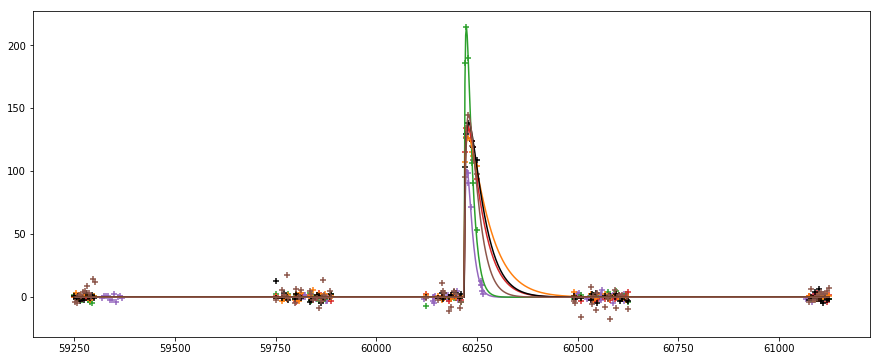

class 42 object_id =  2300
60142.2334 33 5.997335 0.9899000000004889
[8.9960025, 60137.2334, 0.5, 10]
[5.997335, 60087.2334, 0.05, 1.0]
[11.99467, 60142.2334, 5.0, 100]
result: 6.00 60136.19 1.67 1.00 median cov: 11369
60596.095 61 4.307523000000001 3.0714000000007218
[6.461284500000001, 60591.095, 0.5, 10]
[4.307523000000001, 60541.095, 0.05, 1.0]
[8.615046000000001, 60596.095, 5.0, 100]
result: 5.03 60580.07 0.11 4.91 median cov: 118141
59770.3662 11 3.291617 100.0
gap before
[9.051946749999999, 59720.3662, 0.5, 10]
[4.9374255, 59670.3662, 0.05, 1.0]
[13.166468, 59770.3662, 5.0, 100]
result: 13.17 59699.22 0.05 44.10 median cov: 4417
59770.3817 11 18.823622 100.0
gap before
[51.7649605, 59720.3817, 0.5, 10]
[28.235433, 59670.3817, 0.05, 1.0]
[75.294488, 59770.3817, 5.0, 100]
result: 28.24 59670.38 0.20 100.00 median cov: 14
59782.2639 13 20.846098 2.8378000000011525
[31.269147000000004, 59777.2639, 0.5, 10]
[20.846098, 59727.2639, 0.05, 1.0]
[41.692196, 59782.2639, 5.0, 100]
result: 

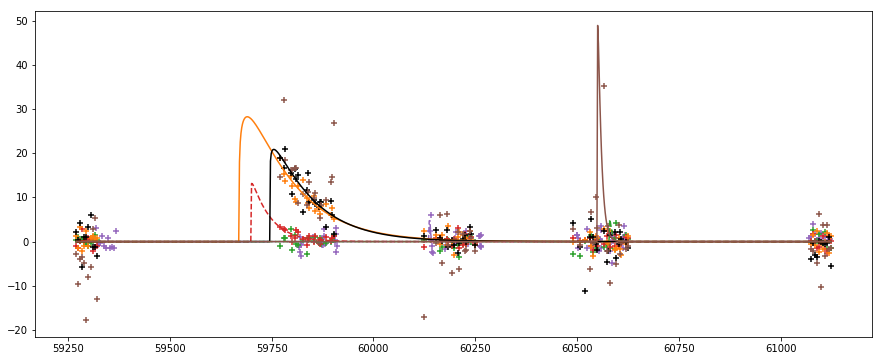

[59670.381700000005, 59746.37405314196]
[59670.381700000005, 59746.37405314196]
phi 59689.3797882855
6.00 1.67 1.00 median cov: 0
4.31 0.05 1.00 median cov: 0
13.17 0.14 42.73 median cov: 1
28.24 0.12 100.00 median cov: 0
25.81 0.32 85.98 median cov: 0
35.22 0.09 100.00 median cov: 0


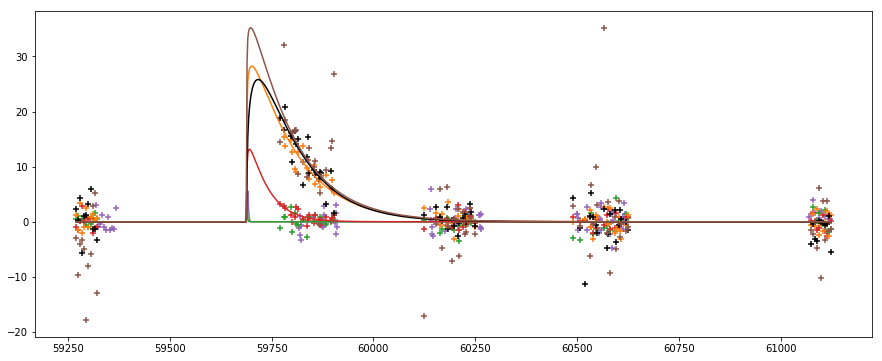

class 42 object_id =  3285
60435.9857 39 27.857284999999997 52.860799999994924
gap before
[76.60753374999999, 60385.9857, 0.5, 10]
[41.7859275, 60335.9857, 0.05, 1.0]
[111.42913999999999, 60435.9857, 5.0, 100]
result: 102.45 60423.00 4.13 1.56 median cov: 0
60403.0258 51 154.806046 3.0089000000007218
[232.209069, 60398.0258, 0.5, 10]
[154.806046, 60348.0258, 0.05, 1.0]
[309.612092, 60403.0258, 5.0, 100]
result: 175.39 60399.60 0.59 12.00 median cov: 0
60414.9975 52 122.826347 11.979299999999057
[184.2395205, 60409.9975, 0.5, 10]
[122.826347, 60359.9975, 0.05, 1.0]
[245.652694, 60414.9975, 5.0, 100]
result: 129.56 60401.11 0.34 24.43 median cov: 2
60415.0127 52 106.12089499999999 11.979299999999057
[159.18134249999997, 60410.0127, 0.5, 10]
[106.12089499999999, 60360.0127, 0.05, 1.0]
[212.24178999999998, 60415.0127, 5.0, 100]
result: 112.52 60403.03 0.05 69.68 median cov: 0
60415.0237 52 114.254494 11.979299999999057
[171.38174099999998, 60410.0237, 0.5, 10]
[114.254494, 60360.0237, 0.05

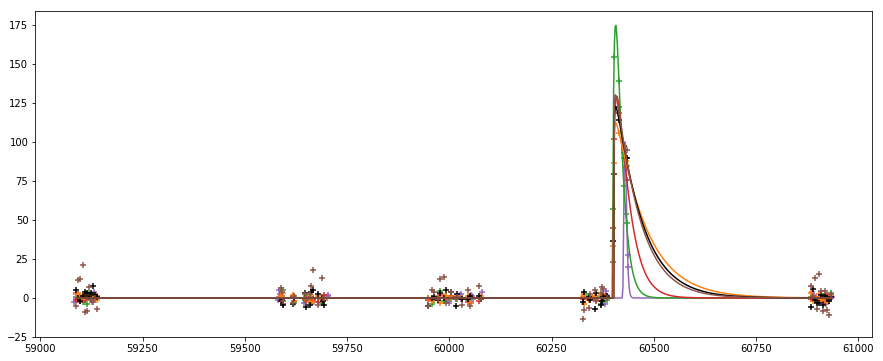

[60399.60241744664, 60401.10526453856, 60403.026483138005, 60403.04355322109]
[60399.60241744664, 60401.10526453856, 60403.026483138005, 60403.04355322109]
phi 60400.83414564245
41.79 2.06 39.43 median cov: 1
179.71 0.44 12.81 median cov: 0
129.10 0.37 23.82 median cov: 0
106.71 0.26 42.61 median cov: 0
114.25 0.39 31.39 median cov: 0
118.78 0.44 27.47 median cov: 0


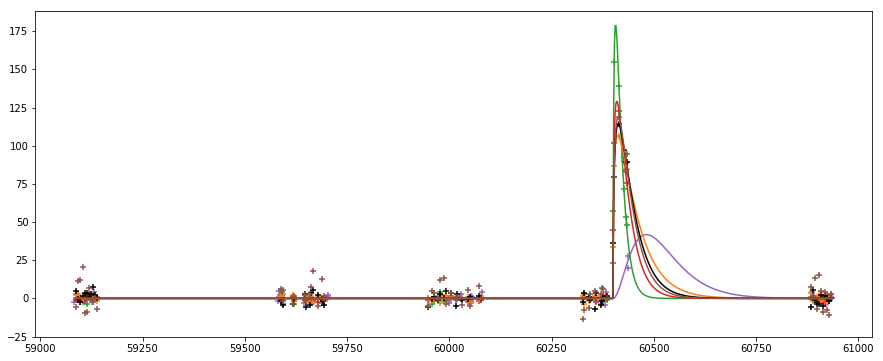

class 52
class 52 object_id =  10757
59908.0487 23 89.204865 1.0006999999968684
[133.8072975, 59903.0487, 0.5, 10]
[89.204865, 59853.0487, 0.05, 1.0]
[178.40973, 59908.0487, 5.0, 100]
result: 89.20 59904.05 0.05 9.49 median cov: 0
59913.2522 24 228.502823 11.200000000004366
[342.7542345, 59908.2522, 0.5, 10]
[228.502823, 59858.2522, 0.05, 1.0]
[457.005646, 59913.2522, 5.0, 100]
result: 231.81 59886.17 5.00 4.66 median cov: 0
59916.0544 25 260.09411600000004 2.809800000002724
[390.1411740000001, 59911.0544, 0.5, 10]
[260.09411600000004, 59861.0544, 0.05, 1.0]
[520.1882320000001, 59916.0544, 5.0, 100]
result: 278.53 59904.17 1.62 8.57 median cov: 0
59916.0697 25 243.139786 2.809800000002724
[364.709679, 59911.0697, 0.5, 10]
[243.139786, 59861.0697, 0.05, 1.0]
[486.279572, 59916.0697, 5.0, 100]
result: 255.78 59907.82 0.69 14.57 median cov: 0
59924.0851 26 246.957092 8.00449999999546
[370.435638, 59919.0851, 0.5, 10]
[246.957092, 59869.0851, 0.05, 1.0]
[493.914184, 59924.0851, 5.0, 100]
r

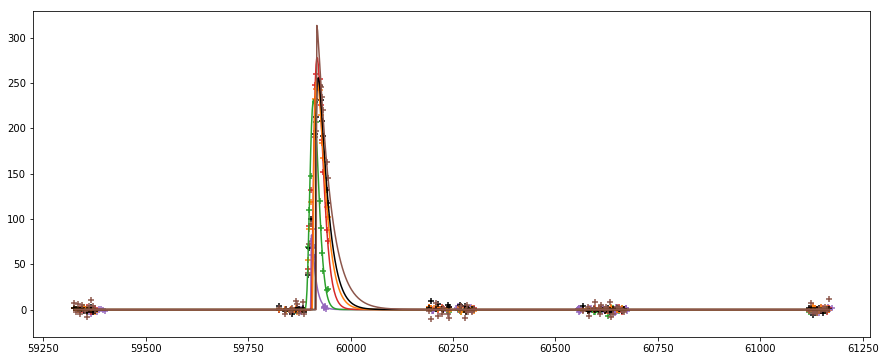

[59886.17173335688, 59904.17187314796, 59907.82303418376, 59914.03805397065]
[59886.17173335688, 59904.17187314796, 59907.82303418376, 59914.03805397065]
phi 59896.084593511376
89.20 0.66 7.93 median cov: 0
250.28 1.70 7.07 median cov: 0
273.00 1.50 11.61 median cov: 0
248.48 1.37 13.89 median cov: 0
246.96 1.77 12.80 median cov: 0
247.52 2.09 12.77 median cov: 0


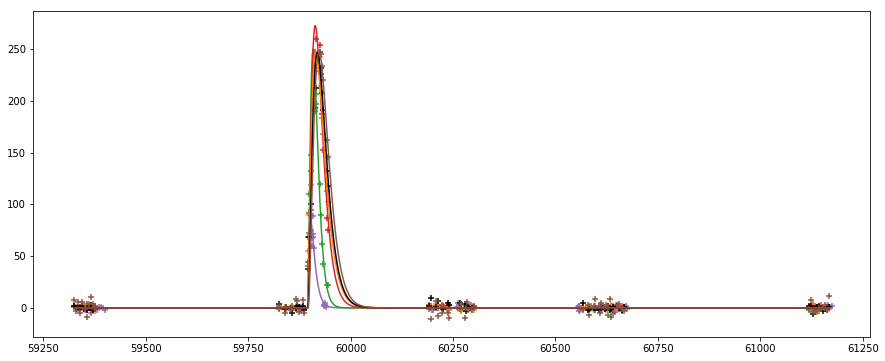

class 52 object_id =  11773
60896.984 43 5.067711847614701 100.0
gap before
gap after
[13.936207580940428, 60846.984, 0.5, 10]
[7.601567771422052, 60796.984, 0.05, 1.0]
[20.270847390458805, 60896.984, 5.0, 100]
result: 7.60 60796.98 0.05 49.29 median cov: 4155631
59962.2019 27 4.680262 4.90570000000298
[7.020393, 59957.2019, 0.5, 10]
[4.680262, 59907.2019, 0.05, 1.0]
[9.360524, 59962.2019, 5.0, 100]
result: 5.62 59907.20 0.05 83.75 median cov: 351
59947.332 25 24.026203 253.33929999999964
gap before
[66.07205825, 59897.332, 0.5, 10]
[36.0393045, 59847.332, 0.05, 1.0]
[96.104812, 59947.332, 5.0, 100]
result: 77.48 59847.33 0.05 70.55 median cov: 32
59947.3472 25 42.182190000000006 253.3391999999949
gap before
[116.00102250000002, 59897.3472, 0.5, 10]
[63.27328500000001, 59847.3472, 0.05, 1.0]
[168.72876000000002, 59947.3472, 5.0, 100]
result: 168.73 59852.56 0.05 56.32 median cov: 23
59947.3582 25 39.860256 253.33929999999964
gap before
[109.615704, 59897.3582, 0.5, 10]
[59.790384, 5984

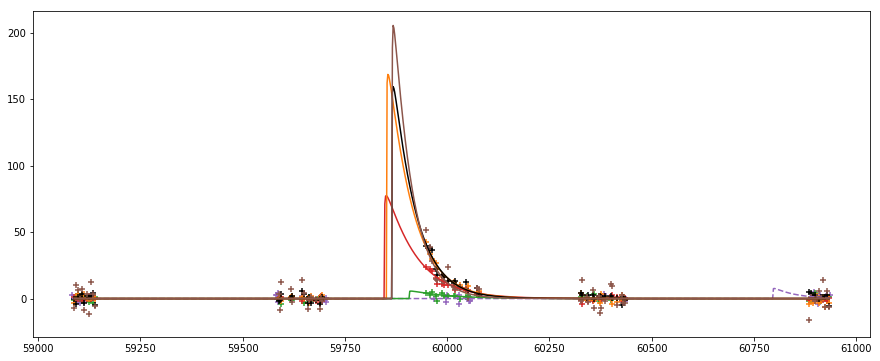

[59907.201900000015, 59847.33200000732, 59852.562192355355, 59865.35742166394]
[59907.201900000015, 59847.33200000732, 59852.562192355355, 59865.35742166394]
phi 59853.145903508484
7.60 0.05 5.08 median cov: 0
9.36 0.06 87.35 median cov: 0
71.65 0.05 70.48 median cov: 0
167.32 0.05 56.28 median cov: 0
159.44 0.13 51.45 median cov: 0
205.53 0.14 43.18 median cov: 1


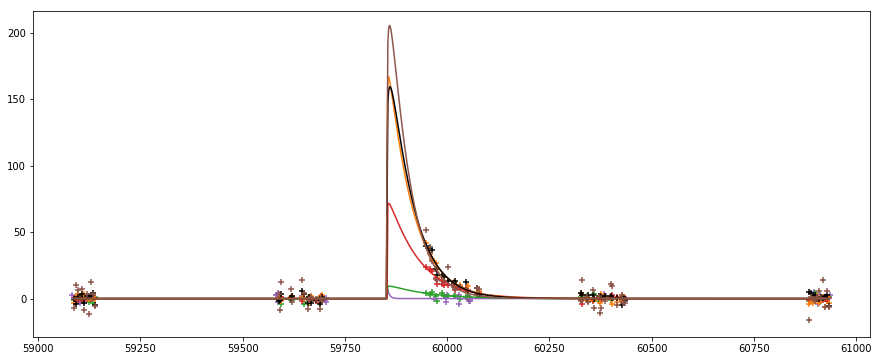

class 52 object_id =  13138
59822.1105 14 6.615659 1.007900000004156
[9.9234885, 59817.1105, 0.5, 10]
[6.615659, 59767.1105, 0.05, 1.0]
[13.231318, 59822.1105, 5.0, 100]
result: 6.62 59815.71 0.62 20.83 median cov: 0
59750.4306 11 759.230164 100.0
gap before
[2087.8829509999996, 59700.4306, 0.5, 10]
[1138.8452459999999, 59650.4306, 0.05, 1.0]
[3036.920656, 59750.4306, 5.0, 100]
result: 3036.92 59721.93 0.05 16.80 median cov: 0
59752.407 12 861.5307619999999 1.9841000000014901
[1292.2961429999998, 59747.407, 0.5, 10]
[861.5307619999999, 59697.407, 0.05, 1.0]
[1723.0615239999997, 59752.407, 5.0, 100]
result: 1723.06 59714.43 0.05 33.96 median cov: 0
59752.4224 12 741.2814940000001 1.9841000000014901
[1111.9222410000002, 59747.4224, 0.5, 10]
[741.2814940000001, 59697.4224, 0.05, 1.0]
[1482.5629880000001, 59752.4224, 5.0, 100]
result: 1482.56 59709.35 0.05 42.00 median cov: 0
59752.4334 12 665.079895 1.9884000000020023
[997.6198425, 59747.4334, 0.5, 10]
[665.079895, 59697.4334, 0.05, 1.0]


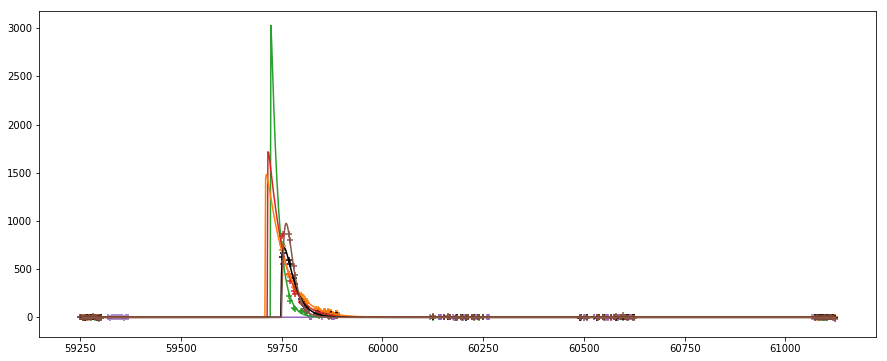

[59721.92882432991, 59714.431504640044, 59709.34936215909, 59748.56796841848]
[59721.92882432991, 59714.431504640044, 59709.34936215909, 59748.56796841848]
phi 59713.76476332203
13.23 0.53 46.38 median cov: 1
3036.92 0.22 16.50 median cov: 0
1723.06 0.05 34.27 median cov: 0
1346.35 0.05 41.87 median cov: 0
678.39 3.16 12.28 median cov: 0
863.07 5.00 8.73 median cov: 0


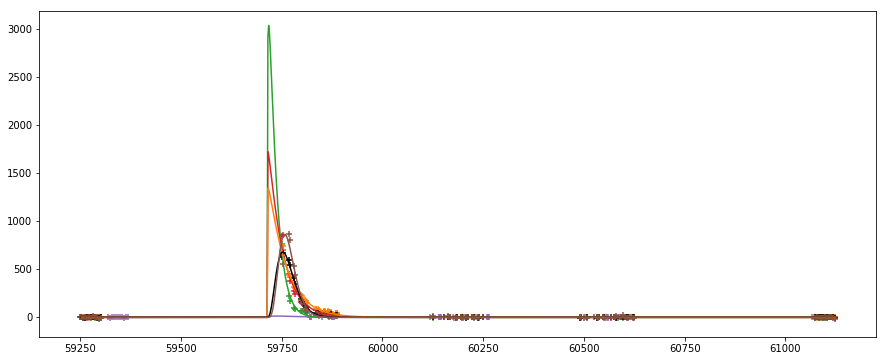

class 52 object_id =  14279
60559.249 54 5.099809 0.995600000002014
[7.649713499999999, 60554.249, 0.5, 10]
[5.099809, 60504.249, 0.05, 1.0]
[10.199618, 60559.249, 5.0, 100]
result: 5.10 60558.25 0.85 5.51 median cov: 0
59825.2676 11 65.512527 100.0
gap before
[180.15944925000002, 59775.2676, 0.5, 10]
[98.26879050000001, 59725.2676, 0.05, 1.0]
[262.050108, 59825.2676, 5.0, 100]
result: 98.27 59768.56 5.00 8.02 median cov: 3
59839.2161 12 99.276337 13.956099999995786
[148.9145055, 59834.2161, 0.5, 10]
[99.276337, 59784.2161, 0.05, 1.0]
[198.552674, 59839.2161, 5.0, 100]
result: 173.32 59825.26 0.07 18.59 median cov: 0
59842.214 13 134.971375 2.9827000000004773
[202.4570625, 59837.214, 0.5, 10]
[134.971375, 59787.214, 0.05, 1.0]
[269.94275, 59842.214, 5.0, 100]
result: 182.44 59825.28 0.07 29.23 median cov: 0
59839.2422 12 119.638626 13.955999999998312
[179.457939, 59834.2422, 0.5, 10]
[119.638626, 59784.2422, 0.05, 1.0]
[239.277252, 59839.2422, 5.0, 100]
result: 129.40 59825.29 0.05 37.

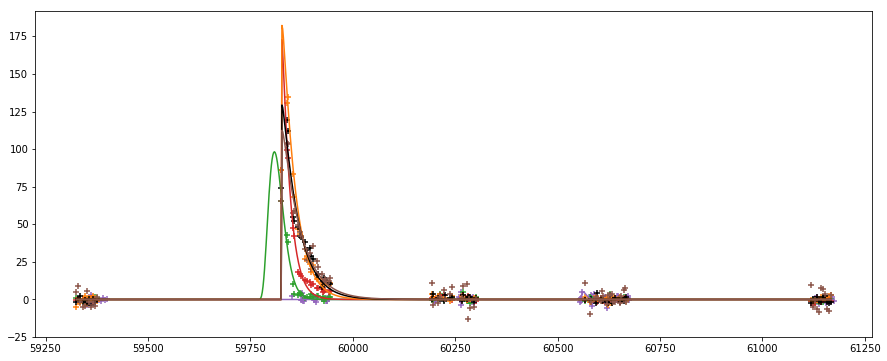

[59768.55604811353, 59825.25996943784, 59825.2751747505, 59825.28617909633]
[59825.25996943784, 59825.2751747505, 59825.28617909633]
phi 59825.26757209417
5.10 0.53 13.67 median cov: 7
121.13 0.07 11.18 median cov: 0
172.73 0.05 19.41 median cov: 0
162.72 0.12 27.63 median cov: 0
120.14 0.10 35.57 median cov: 0
104.34 0.10 39.98 median cov: -0


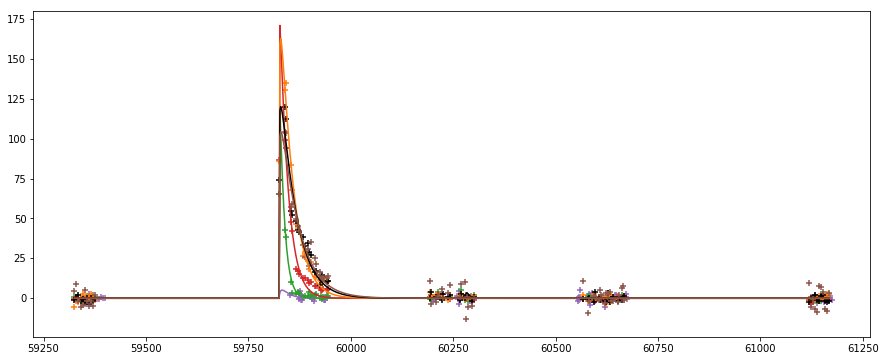

class 52 object_id =  15718
60261.0632 38 28.393259000000004 0.985899999999674
[42.58988850000001, 60256.0632, 0.5, 10]
[28.393259000000004, 60206.0632, 0.05, 1.0]
[56.78651800000001, 60261.0632, 5.0, 100]
result: 28.43 60259.22 0.67 3.06 median cov: 0
60267.0519 40 64.29409799999999 25.910100000000966
[96.44114699999999, 60262.0519, 0.5, 10]
[64.29409799999999, 60212.0519, 0.05, 1.0]
[128.58819599999998, 60267.0519, 5.0, 100]
result: 71.51 60267.03 0.05 8.99 median cov: 0
60267.0443 40 75.335854 25.910100000000966
[113.003781, 60262.0443, 0.5, 10]
[75.335854, 60212.0443, 0.05, 1.0]
[150.671708, 60267.0443, 5.0, 100]
result: 75.75 60266.48 0.05 18.09 median cov: 0
60267.0595 40 71.516266 25.910000000003492
[107.274399, 60262.0595, 0.5, 10]
[71.516266, 60212.0595, 0.05, 1.0]
[143.032532, 60267.0595, 5.0, 100]
result: 143.03 60245.07 0.05 23.94 median cov: 2
60270.1344 41 61.661469 3.063900000001013
[92.49220349999999, 60265.1344, 0.5, 10]
[61.661469, 60215.1344, 0.05, 1.0]
[123.322938, 

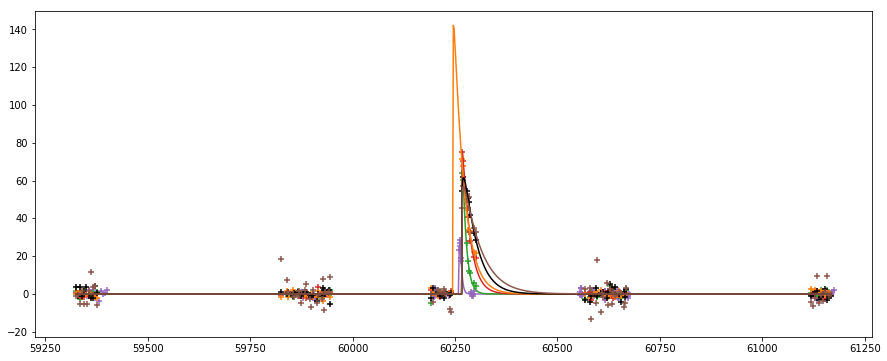

[60267.0312835569, 60266.48001391918, 60245.07359824112, 60266.120334932304]
[60267.0312835569, 60266.48001391918, 60245.07359824112, 60266.120334932304]
phi 60255.68688633343
28.39 4.42 1.32 median cov: 0
80.37 0.80 7.42 median cov: 0
94.39 0.20 17.56 median cov: 0
95.61 0.05 23.45 median cov: 0
61.66 0.76 18.40 median cov: 0
56.90 0.27 36.35 median cov: 0


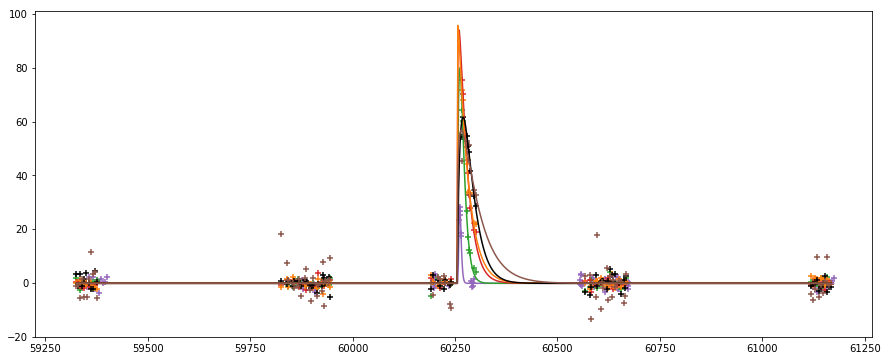

class 62
class 62 object_id =  3910
60502.2441 59 4.828198 0.9892000000036205
[7.242297000000001, 60497.2441, 0.5, 10]
[4.828198, 60447.2441, 0.05, 1.0]
[9.656396, 60502.2441, 5.0, 100]
result: 5.46 60499.22 2.15 2.14 median cov: 36
60546.1263 54 28.802496 7.953600000000733
[43.203744, 60541.1263, 0.5, 10]
[28.802496, 60491.1263, 0.05, 1.0]
[57.604992, 60546.1263, 5.0, 100]
result: 32.36 60535.72 5.00 1.69 median cov: 25
60546.1186 54 67.834053 7.953600000000733
[101.7510795, 60541.1186, 0.5, 10]
[67.834053, 60491.1186, 0.05, 1.0]
[135.668106, 60546.1186, 5.0, 100]
result: 71.29 60536.85 3.50 2.25 median cov: 0
60546.1341 54 100.696465 7.953700000005483
[151.0446975, 60541.1341, 0.5, 10]
[100.696465, 60491.1341, 0.05, 1.0]
[201.39293, 60546.1341, 5.0, 100]
result: 144.28 60538.18 0.54 6.01 median cov: 0
60546.1452 54 125.06008100000001 7.953699999998207
[187.5901215, 60541.1452, 0.5, 10]
[125.06008100000001, 60491.1452, 0.05, 1.0]
[250.12016200000002, 60546.1452, 5.0, 100]
result: 187.

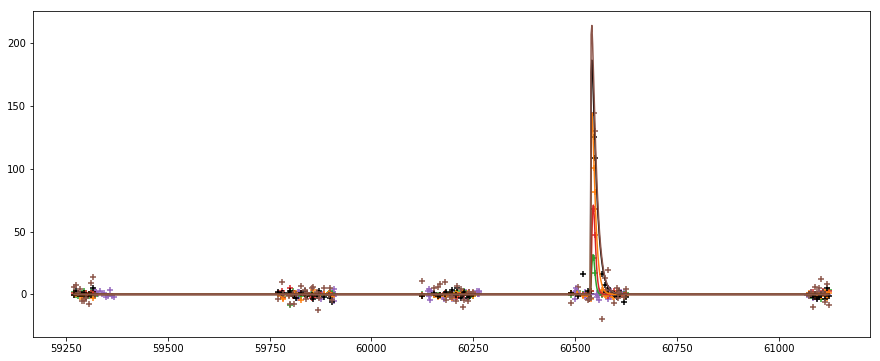

[60535.71924490975, 60536.846887203596, 60538.18066514925, 60538.192632177925]
[60535.71924490975, 60536.846887203596, 60538.18066514925, 60538.192632177925]
phi 60536.616510543085
4.86 0.08 1.00 median cov: 3950888732775
33.52 3.59 2.01 median cov: 0
70.84 3.88 2.12 median cov: 0
100.70 5.00 1.90 median cov: -0
125.06 3.01 3.27 median cov: 0
145.49 5.00 2.05 median cov: 0


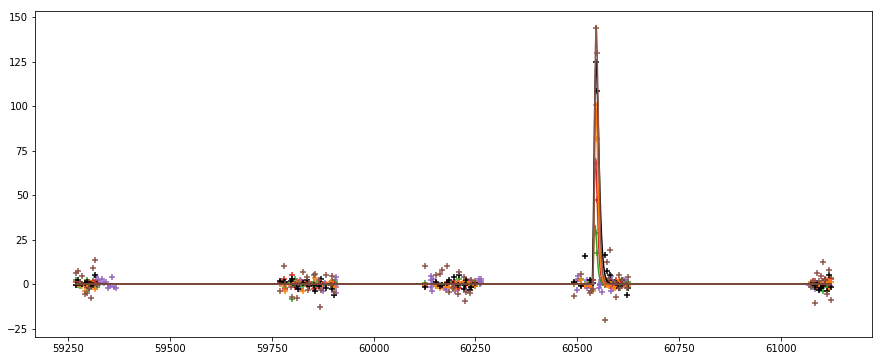

class 62 object_id =  7703
60201.2281 34 6.864739999999999 0.9967000000033295
[10.29711, 60196.2281, 0.5, 10]
[6.864739999999999, 60146.2281, 0.05, 1.0]
[13.729479999999999, 60201.2281, 5.0, 100]
result: 6.86 60189.30 5.00 4.35 median cov: 28
60192.3006 32 39.355915 247.21600000000035
gap before
[108.22876625, 60142.3006, 0.5, 10]
[59.0338725, 60092.3006, 0.05, 1.0]
[157.42366, 60192.3006, 5.0, 100]
result: 59.03 60092.30 4.86 14.53 median cov: 1
60192.293 32 111.532478 247.21600000000035
gap before
[306.7143145, 60142.293, 0.5, 10]
[167.298717, 60092.293, 0.05, 1.0]
[446.129912, 60192.293, 5.0, 100]
result: 167.33 60092.29 0.76 52.97 median cov: 1
60192.3082 32 157.404678 247.21600000000035
gap before
[432.8628645, 60142.3082, 0.5, 10]
[236.10701699999998, 60092.3082, 0.05, 1.0]
[629.618712, 60192.3082, 5.0, 100]
result: 629.62 60128.52 0.05 39.19 median cov: 0
60192.3192 32 134.46138 247.21600000000035
gap before
[369.76879499999995, 60142.3192, 0.5, 10]
[201.69207, 60092.3192, 0.05,

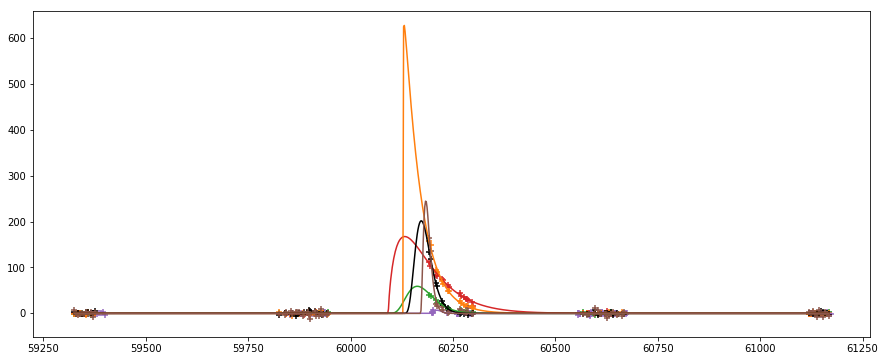

[60092.300600020506, 60092.2931326027, 60128.521394641575, 60129.73675830367]
[60092.300600020506, 60092.2931326027, 60128.521394641575, 60129.73675830367]
phi 60101.35206496687
6.86 5.00 11.33 median cov: 79
59.03 4.04 15.42 median cov: 0
167.30 0.61 55.18 median cov: 0
629.62 0.40 35.47 median cov: 0
384.94 5.00 10.16 median cov: 0
654.24 5.00 9.12 median cov: 0


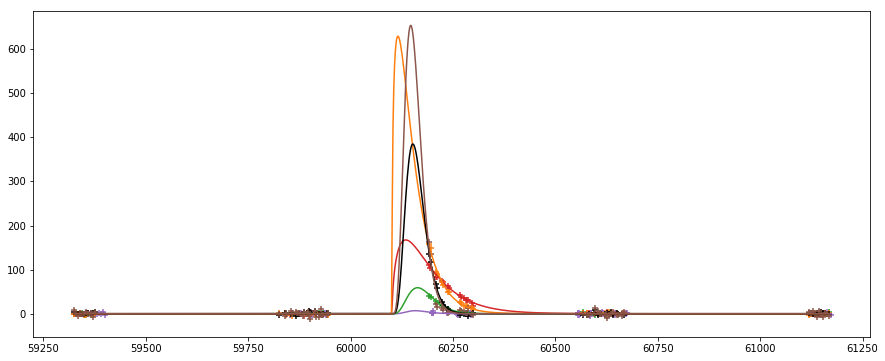

class 62 object_id =  11770
59822.1105 14 6.706411 1.007900000004156
[10.0596165, 59817.1105, 0.5, 10]
[6.706411, 59767.1105, 0.05, 1.0]
[13.412822, 59822.1105, 5.0, 100]
result: 6.71 59815.85 5.00 2.64 median cov: 35
60237.2283 47 8.292313 10.205500000003667
[12.4384695, 60232.2283, 0.5, 10]
[8.292313, 60182.2283, 0.05, 1.0]
[16.584626, 60237.2283, 5.0, 100]
result: 9.25 60234.03 2.99 1.42 median cov: 0
60237.2206 47 32.864902 10.205500000003667
[49.297353, 60232.2206, 0.5, 10]
[32.864902, 60182.2206, 0.05, 1.0]
[65.729804, 60237.2206, 5.0, 100]
result: 54.36 60232.93 0.18 4.32 median cov: 0
60237.2359 47 65.697731 10.205399999998917
[98.5465965, 60232.2359, 0.5, 10]
[65.697731, 60182.2359, 0.05, 1.0]
[131.395462, 60237.2359, 5.0, 100]
result: 99.67 60231.40 0.48 4.14 median cov: 0
60237.2468 47 93.654999 10.20520000000397
[140.48249850000002, 60232.2468, 0.5, 10]
[93.654999, 60182.2468, 0.05, 1.0]
[187.309998, 60237.2468, 5.0, 100]
result: 98.09 60227.31 2.92 2.86 median cov: 0
60237

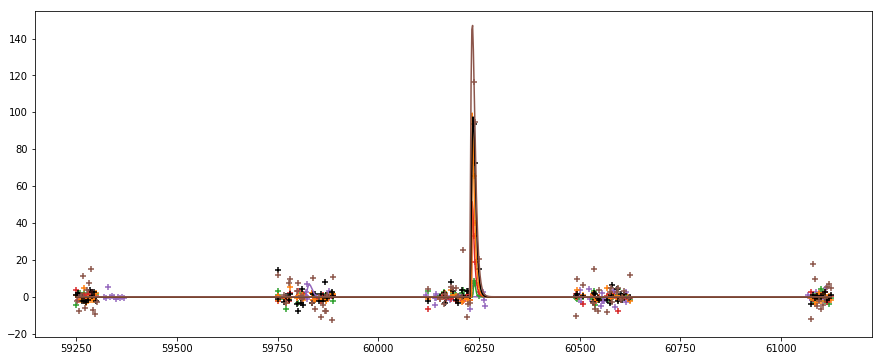

[60234.03361570973, 60232.93188168953, 60231.40391229186, 60227.306157451865]
[60234.03361570973, 60232.93188168953, 60231.40391229186, 60227.306157451865]
phi 60229.73702722128
13.41 4.25 2.06 median cov: 210
8.37 5.00 1.55 median cov: 0
65.73 0.54 3.91 median cov: 0
110.85 0.66 4.00 median cov: 0
96.81 1.97 3.19 median cov: 0
118.02 2.17 3.12 median cov: 0


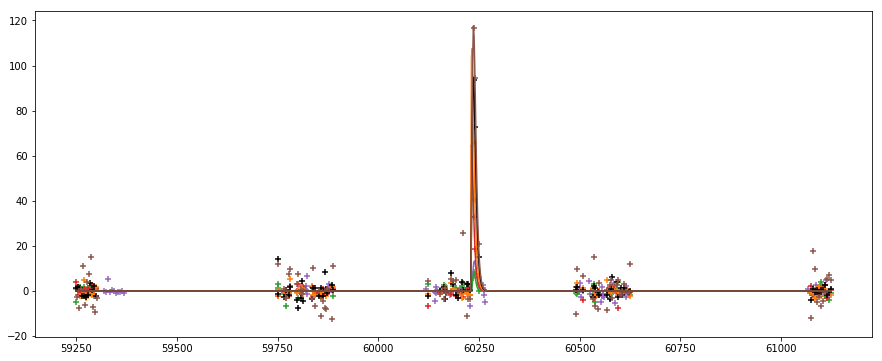

class 62 object_id =  17370
60500.2524 57 45.730022 0.9945000000006985
[68.595033, 60495.2524, 0.5, 10]
[45.730022, 60445.2524, 0.05, 1.0]
[91.460044, 60500.2524, 5.0, 100]
result: 45.73 60445.25 3.45 12.64 median cov: 0
60508.3203 49 86.508408 16.968000000000757
[129.762612, 60503.3203, 0.5, 10]
[86.508408, 60453.3203, 0.05, 1.0]
[173.016816, 60508.3203, 5.0, 100]
result: 87.30 60480.88 2.16 14.42 median cov: 0
60520.4204 50 138.62158200000002 12.107800000005227
[207.93237300000004, 60515.4204, 0.5, 10]
[138.62158200000002, 60465.4204, 0.05, 1.0]
[277.24316400000004, 60520.4204, 5.0, 100]
result: 140.09 60492.99 1.24 21.76 median cov: 0
60532.2696 51 176.939102 11.833899999997811
[265.40865299999996, 60527.2696, 0.5, 10]
[176.939102, 60477.2696, 0.05, 1.0]
[353.878204, 60532.2696, 5.0, 100]
result: 176.94 60480.58 2.03 22.69 median cov: 0
60535.1995 52 202.505997 2.9187000000019907
[303.7589955, 60530.1995, 0.5, 10]
[202.505997, 60480.1995, 0.05, 1.0]
[405.011994, 60535.1995, 5.0, 100

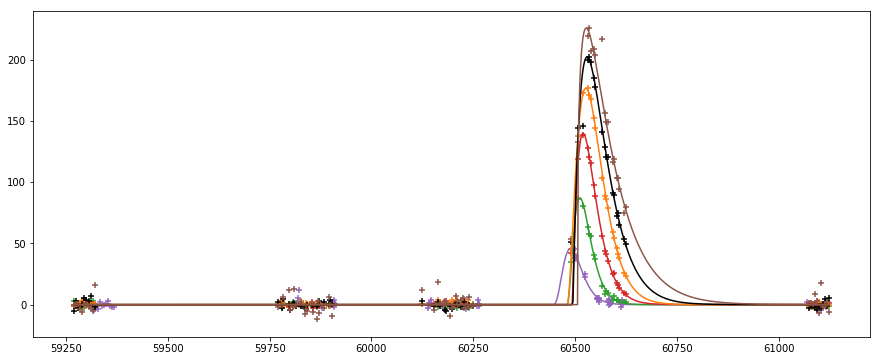

[60480.87993042788, 60492.99311830113, 60480.5788271467, 60494.8651866918]
[60480.87993042788, 60492.99311830113, 60480.5788271467, 60494.8651866918]
phi 60483.7576757556
45.73 2.32 9.55 median cov: 0
88.93 1.74 15.71 median cov: 0
139.07 1.75 20.02 median cov: -0
177.37 1.72 24.39 median cov: 0
202.51 1.60 29.17 median cov: 0
226.12 1.71 30.63 median cov: 0


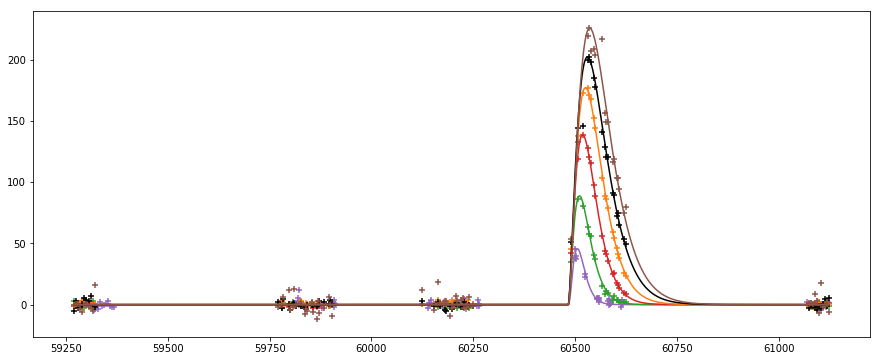

class 62 object_id =  18645
60141.2435 32 4.856072 1.0031999999991967
[7.284108, 60136.2435, 0.5, 10]
[4.856072, 60086.2435, 0.05, 1.0]
[9.712144, 60141.2435, 5.0, 100]
result: 4.93 60089.88 0.08 1.42 median cov: 0
60538.1727 53 5.462331 2.99210000000312
[8.1934965, 60533.1727, 0.5, 10]
[5.462331, 60483.1727, 0.05, 1.0]
[10.924662, 60538.1727, 5.0, 100]
result: 8.33 60537.58 0.05 1.00 median cov: 3348222152662056448
60491.3446 48 7.095283 242.2632999999987
gap before
[19.51202825, 60441.3446, 0.5, 10]
[10.6429245, 60391.3446, 0.05, 1.0]
[28.381132, 60491.3446, 5.0, 100]
result: 10.64 60391.34 4.19 16.42 median cov: 198
60491.36 48 14.542692 242.26340000000346
gap before
[39.992403, 60441.36, 0.5, 10]
[21.814038, 60391.36, 0.05, 1.0]
[58.170768, 60491.36, 5.0, 100]
result: 21.81 60391.36 3.96 17.24 median cov: 14
60520.4414 50 7.665682 12.102300000005926
[11.498523, 60515.4414, 0.5, 10]
[7.665682, 60465.4414, 0.05, 1.0]
[15.331364, 60520.4414, 5.0, 100]
result: 10.95 60508.34 0.42 8.66 

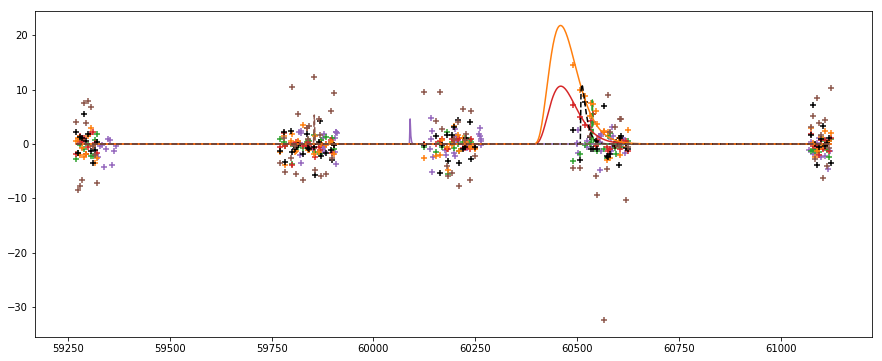

[60391.344600010285, 60391.36000014806]
[60391.344600010285, 60391.36000014806]
phi 60391.34845004473
4.93 0.08 1.42 median cov: 0
8.33 0.05 1.00 median cov: 0
10.64 4.19 16.42 median cov: 4
21.81 3.96 17.24 median cov: 2
15.33 5.00 8.09 median cov: 46544
24.50 0.05 1.00 median cov: 0


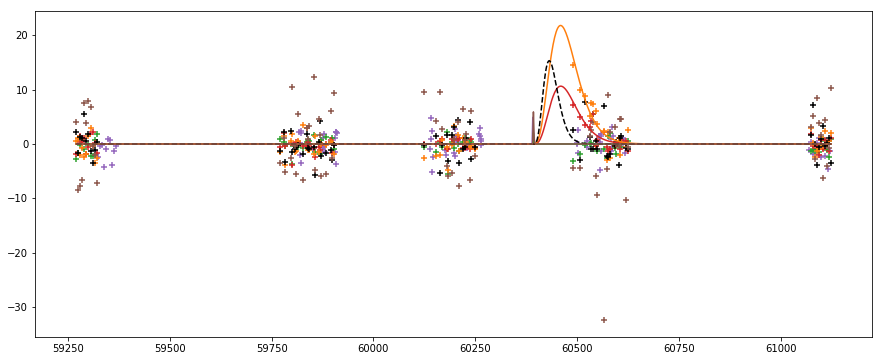

class 67
class 67 object_id =  2922
60118.4163 24 16.806917000000002 238.39049999999406
gap before
[46.21902175000001, 60068.4163, 0.5, 10]
[25.210375500000005, 60018.4163, 0.05, 1.0]
[67.22766800000001, 60118.4163, 5.0, 100]
result: 67.23 60086.56 0.05 19.58 median cov: 529
60124.2618 33 56.288123999999996 237.22430000000168
gap before
[154.792341, 60074.2618, 0.5, 10]
[84.432186, 60024.2618, 0.05, 1.0]
[225.15249599999999, 60124.2618, 5.0, 100]
result: 225.15 60065.90 0.05 31.61 median cov: 12
60124.2541 33 294.855255 237.22430000000168
gap before
[810.85195125, 60074.2541, 0.5, 10]
[442.2828825, 60024.2541, 0.05, 1.0]
[1179.42102, 60124.2541, 5.0, 100]
result: 1179.42 60086.08 0.05 22.76 median cov: 0
60124.2695 33 491.29351799999995 237.22439999999915
gap before
[1351.0571744999997, 60074.2695, 0.5, 10]
[736.9402769999999, 60024.2695, 0.05, 1.0]
[1965.1740719999998, 60124.2695, 5.0, 100]
result: 1965.17 60093.41 0.05 18.85 median cov: 0
60124.2807 33 477.137726 237.2245000000039
ga

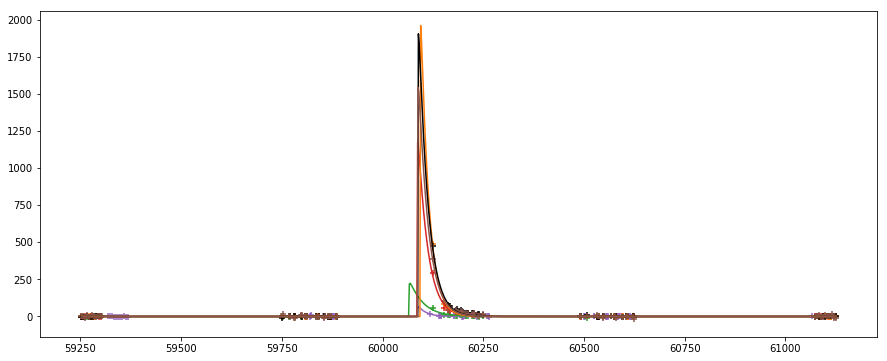

[60065.89906630052, 60086.084494801966, 60093.41251511923, 60087.60901055699]
[60065.89906630052, 60086.084494801966, 60093.41251511923, 60087.60901055699]
phi 60076.37290949
67.23 0.30 18.15 median cov: 0
165.56 0.05 31.40 median cov: 0
1179.42 0.22 21.88 median cov: 0
1965.17 0.55 16.67 median cov: 0
1908.55 0.27 21.00 median cov: 0
1551.32 0.27 21.31 median cov: 0


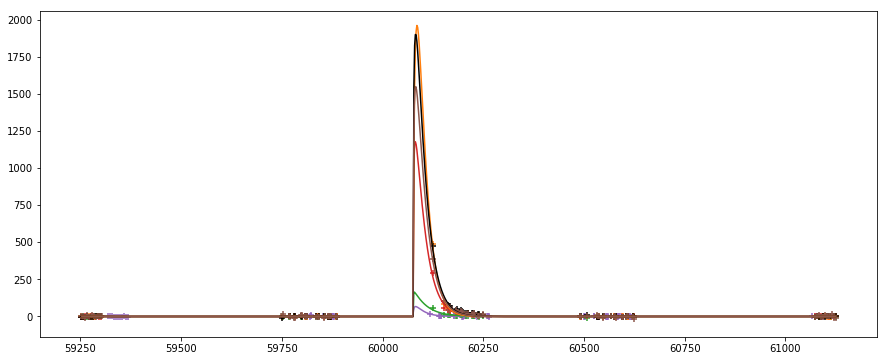

class 67 object_id =  3041
59820.1047 12 3.7387639999999998 0.9515000000028522
[5.608146, 59815.1047, 0.5, 10]
[3.7387639999999998, 59765.1047, 0.05, 1.0]
[7.4775279999999995, 59820.1047, 5.0, 100]
result: 3.74 59807.25 5.00 1.53 median cov: 16800
60538.2428 55 5.192554 3.1097999999983585
[7.788831, 60533.2428, 0.5, 10]
[5.192554, 60483.2428, 0.05, 1.0]
[10.385108, 60538.2428, 5.0, 100]
result: 5.92 60535.13 0.30 7.63 median cov: 112
60490.2647 50 18.512936 241.2309000000023
gap before
[50.910574, 60440.2647, 0.5, 10]
[27.769404, 60390.2647, 0.05, 1.0]
[74.051744, 60490.2647, 5.0, 100]
result: 74.05 60424.19 0.05 39.20 median cov: 48
60493.2527 51 17.764956 2.9724999999962165
[26.647434000000004, 60488.2527, 0.5, 10]
[17.764956, 60438.2527, 0.05, 1.0]
[35.529912, 60493.2527, 5.0, 100]
result: 17.76 60489.85 0.05 37.32 median cov: 0
60493.2639 51 28.498444 2.9726000000009662
[42.747665999999995, 60488.2639, 0.5, 10]
[28.498444, 60438.2639, 0.05, 1.0]
[56.996888, 60493.2639, 5.0, 100]
re

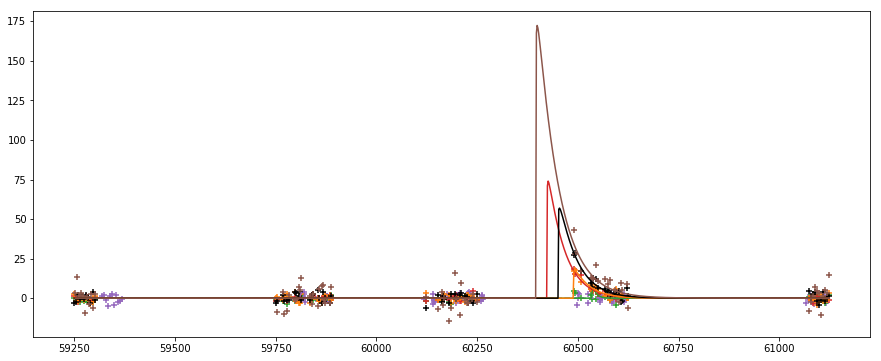

[60535.13309343381, 60424.187319334815, 60489.845298758286, 60451.367467940996]
[60424.187319334815, 60489.845298758286, 60451.367467940996]
phi 60437.77739363791
3.74 5.00 1.53 median cov: 0
5.19 0.18 63.87 median cov: 0
53.20 0.05 39.06 median cov: 0
35.53 0.26 37.78 median cov: 0
57.00 0.24 38.75 median cov: 0
79.43 0.05 50.25 median cov: 0


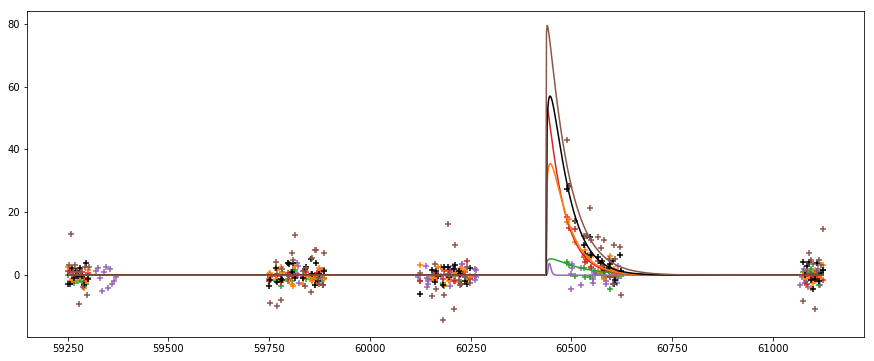

class 67 object_id =  19154
60141.2225 26 5.205078 0.9935000000041327
[7.8076170000000005, 60136.2225, 0.5, 10]
[5.205078, 60086.2225, 0.05, 1.0]
[10.410156, 60141.2225, 5.0, 100]
result: 5.88 60118.42 0.22 6.23 median cov: 3440528
60609.0323 66 40.330582 3.0020000000004075
[60.495873, 60604.0323, 0.5, 10]
[40.330582, 60554.0323, 0.05, 1.0]
[80.661164, 60609.0323, 5.0, 100]
result: 40.45 60594.67 5.00 2.92 median cov: 0
60609.0247 66 134.421982 3.002200000002631
[201.63297300000002, 60604.0247, 0.5, 10]
[134.421982, 60554.0247, 0.05, 1.0]
[268.843964, 60609.0247, 5.0, 100]
result: 145.09 60595.05 4.29 3.98 median cov: 0
60609.04 66 195.192749 3.0020999999978812
[292.78912349999996, 60604.04, 0.5, 10]
[195.192749, 60554.04, 0.05, 1.0]
[390.385498, 60609.04, 5.0, 100]
result: 236.53 60593.34 4.79 4.39 median cov: 0
60621.1996 67 191.90567 12.148600000000442
[287.858505, 60616.1996, 0.5, 10]
[191.90567, 60566.1996, 0.05, 1.0]
[383.81134, 60621.1996, 5.0, 100]
result: 248.05 60607.61 0.44 

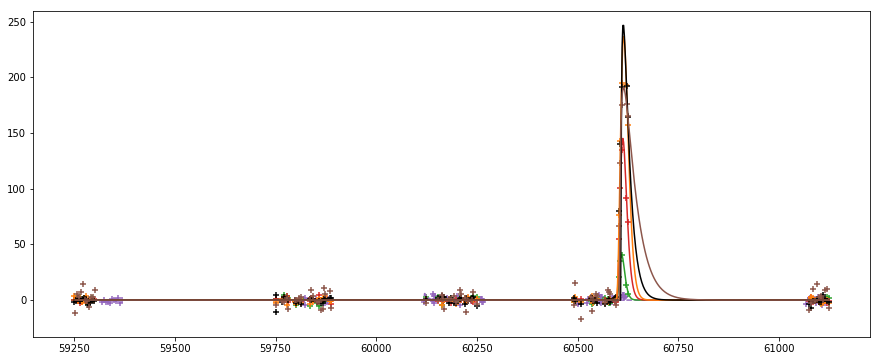

[60594.66510732247, 60595.04718057588, 60593.341932492665, 60607.60928661784]
[60594.66510732247, 60595.04718057588, 60593.341932492665, 60607.60928661784]
phi 60594.09903822092
10.41 2.39 3.75 median cov: 6
40.33 5.00 3.05 median cov: 0
146.09 4.90 3.69 median cov: 0
235.25 4.34 4.66 median cov: 0
228.22 3.96 5.18 median cov: 0
214.00 4.15 5.05 median cov: 0


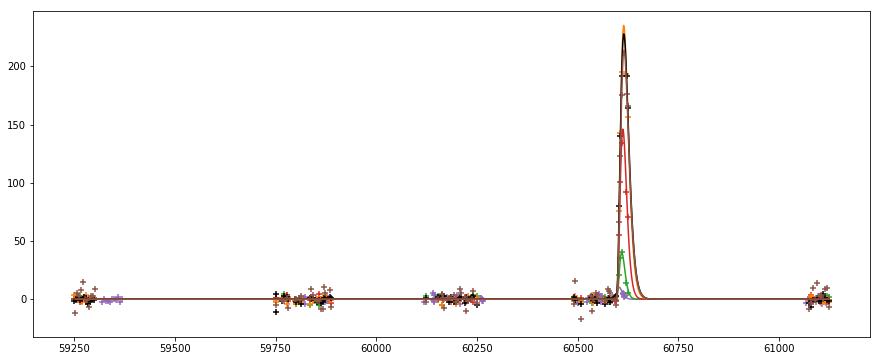

class 67 object_id =  28636
60612.1183 63 9.805061 23.951700000005076
[14.7075915, 60607.1183, 0.5, 10]
[9.805061, 60557.1183, 0.05, 1.0]
[19.610122, 60612.1183, 5.0, 100]
result: 14.08 60588.17 0.05 27.16 median cov: 76
60605.1456 53 130.076782 8.956000000005588
[195.11517300000003, 60600.1456, 0.5, 10]
[130.076782, 60550.1456, 0.05, 1.0]
[260.153564, 60605.1456, 5.0, 100]
result: 246.82 60596.19 0.05 10.78 median cov: 0
60605.138 53 344.063904 8.955999999998312
[516.0958559999999, 60600.138, 0.5, 10]
[344.063904, 60550.138, 0.05, 1.0]
[688.127808, 60605.138, 5.0, 100]
result: 467.00 60596.18 0.13 15.52 median cov: 0
60608.146 54 492.30481 2.9927999999999884
[738.4572149999999, 60603.146, 0.5, 10]
[492.30481, 60553.146, 0.05, 1.0]
[984.60962, 60608.146, 5.0, 100]
result: 527.31 60605.10 0.05 16.83 median cov: 0
60608.1569 54 423.81881699999997 2.9927000000025146
[635.7282255, 60603.1569, 0.5, 10]
[423.81881699999997, 60553.1569, 0.05, 1.0]
[847.6376339999999, 60608.1569, 5.0, 100]
res

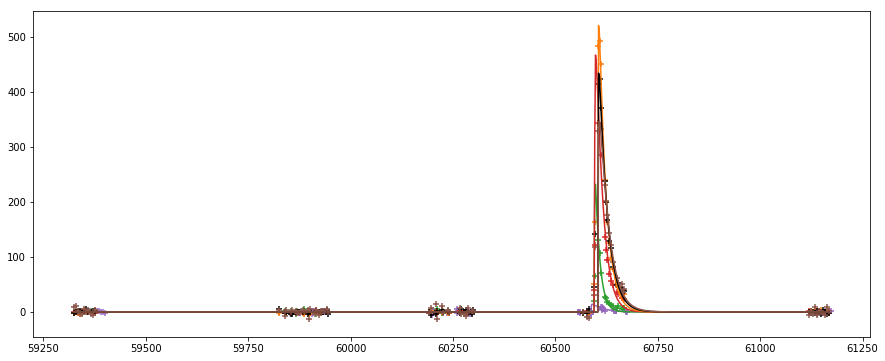

[60596.18961255129, 60596.18184456956, 60605.09514772703, 60605.0417084333]
[60596.18961255129, 60596.18184456956, 60605.09514772703, 60605.0417084333]
phi 60598.39875253093
9.89 0.05 27.08 median cov: 0
204.97 0.05 10.68 median cov: 0
463.02 0.05 16.99 median cov: 0
548.38 0.23 15.76 median cov: 0
445.79 0.25 17.70 median cov: 0
339.78 0.47 17.08 median cov: 0


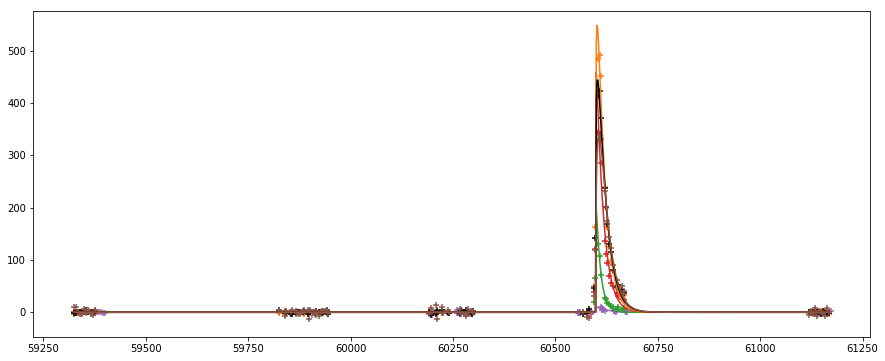

class 67 object_id =  34437
59582.3282 11 4.279237999999999 100.0
gap before
[11.767904499999998, 59532.3282, 0.5, 10]
[6.418856999999999, 59482.3282, 0.05, 1.0]
[17.116951999999998, 59582.3282, 5.0, 100]
result: 9.70 59512.08 0.14 3.57 median cov: 5173752123421116
59947.3396 25 5.4109739999999995 253.33920000000217
gap before
[14.8801785, 59897.3396, 0.5, 10]
[8.116461, 59847.3396, 0.05, 1.0]
[21.643895999999998, 59947.3396, 5.0, 100]
result: 21.64 59857.25 0.05 42.22 median cov: 10101
59947.332 25 21.072142000000003 253.33929999999964
gap before
[57.94839050000001, 59897.332, 0.5, 10]
[31.608213000000006, 59847.332, 0.05, 1.0]
[84.28856800000001, 59947.332, 5.0, 100]
result: 84.29 59888.98 0.05 33.24 median cov: 38
59947.3472 25 59.543064 253.3391999999949
gap before
[163.743426, 59897.3472, 0.5, 10]
[89.314596, 59847.3472, 0.05, 1.0]
[238.172256, 59947.3472, 5.0, 100]
result: 238.17 59896.74 0.05 29.30 median cov: 4
59947.3582 25 78.112511 253.33929999999964
gap before
[214.80940525

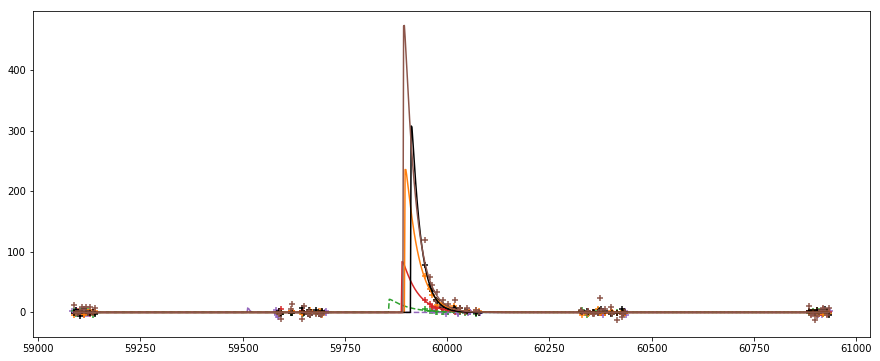

[59888.9823465233, 59896.74133746676, 59911.84000853556]
[59888.9823465233, 59896.74133746676, 59911.84000853556]
phi 59892.86184199503
17.12 5.00 6.79 median cov: 7896
9.86 0.05 41.34 median cov: 0
75.69 0.05 33.14 median cov: 0
238.17 0.08 29.57 median cov: 0
312.45 0.52 18.85 median cov: 0
479.44 0.05 26.50 median cov: 0


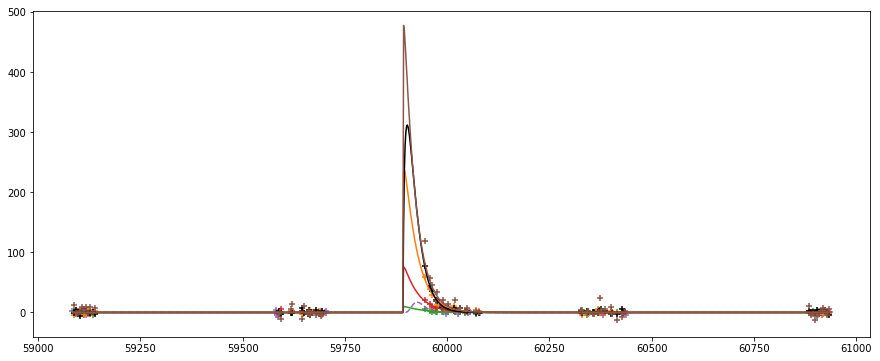

class 90
class 90 object_id =  745
60140.2403 31 18.014029 230.17179999999644
gap before
[49.538579750000004, 60090.2403, 0.5, 10]
[27.0210435, 60040.2403, 0.05, 1.0]
[72.056116, 60140.2403, 5.0, 100]
result: 72.06 60063.98 0.05 42.08 median cov: 252
60125.4171 32 192.244293 223.31790000000183
gap before
[528.67180575, 60075.4171, 0.5, 10]
[288.3664395, 60025.4171, 0.05, 1.0]
[768.977172, 60125.4171, 5.0, 100]
result: 768.98 60099.90 0.05 15.83 median cov: 0
60125.4094 32 220.79521200000002 223.31779999999708
gap before
[607.1868330000001, 60075.4094, 0.5, 10]
[331.19281800000005, 60025.4094, 0.05, 1.0]
[883.1808480000001, 60125.4094, 5.0, 100]
result: 883.18 60083.56 0.05 25.90 median cov: 0
60125.4248 32 203.250702 223.3179999999993
gap before
[558.9394305, 60075.4248, 0.5, 10]
[304.87605299999996, 60025.4248, 0.05, 1.0]
[813.002808, 60125.4248, 5.0, 100]
result: 304.88 60054.70 1.36 26.48 median cov: 0
60125.4357 32 183.633118 223.31790000000183
gap before
[504.99107449999997, 60075

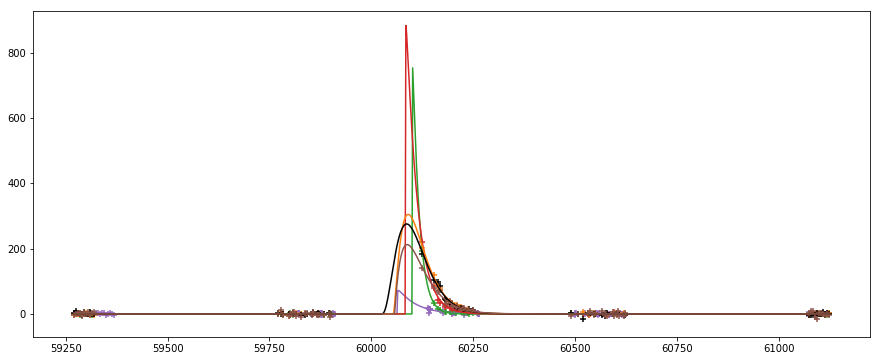

[60099.902254471104, 60083.56312663786, 60054.70209606186, 60025.4357204791]
[60099.902254471104, 60083.56312663786, 60054.70209606186, 60025.4357204791]
phi 60047.28416591448
72.06 0.21 40.27 median cov: 0
768.98 3.73 9.85 median cov: 0
883.18 1.02 20.90 median cov: 0
304.88 1.67 25.23 median cov: 0
275.45 1.66 25.81 median cov: 0
218.29 1.22 30.51 median cov: 0


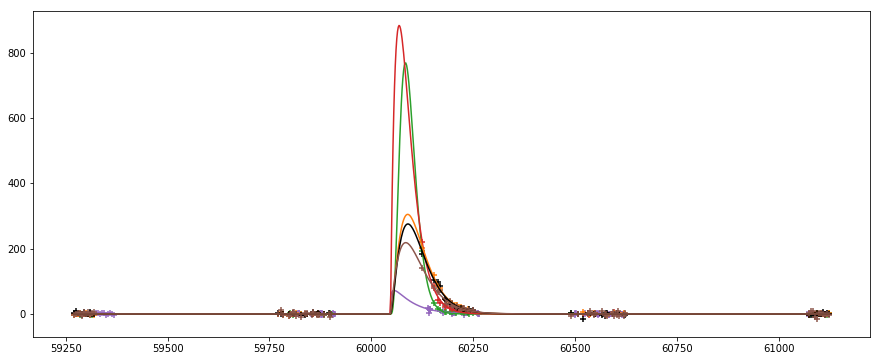

class 90 object_id =  1124
60499.2467 48 5.330927 235.2002000000066
gap before
[14.66004925, 60449.2467, 0.5, 10]
[7.9963905, 60399.2467, 0.05, 1.0]
[21.323708, 60499.2467, 5.0, 100]
result: 8.00 60399.25 0.05 88.03 median cov: 45397
60490.2725 50 37.170177 241.23099999999977
gap before
[102.21798675000001, 60440.2725, 0.5, 10]
[55.75526550000001, 60390.2725, 0.05, 1.0]
[148.680708, 60490.2725, 5.0, 100]
result: 140.64 60390.27 0.05 61.59 median cov: 52
60490.2647 50 106.671692 241.2309000000023
gap before
[293.347153, 60440.2647, 0.5, 10]
[160.00753799999998, 60390.2647, 0.05, 1.0]
[426.686768, 60490.2647, 5.0, 100]
result: 426.69 60409.84 0.05 47.65 median cov: 1
60490.2802 50 139.818405 241.23099999999977
gap before
[384.50061375000007, 60440.2802, 0.5, 10]
[209.72760750000003, 60390.2802, 0.05, 1.0]
[559.27362, 60490.2802, 5.0, 100]
result: 559.27 60426.66 0.05 37.78 median cov: 0
60490.2913 50 143.600189 241.23109999999724
gap before
[394.90051975, 60440.2913, 0.5, 10]
[215.400283

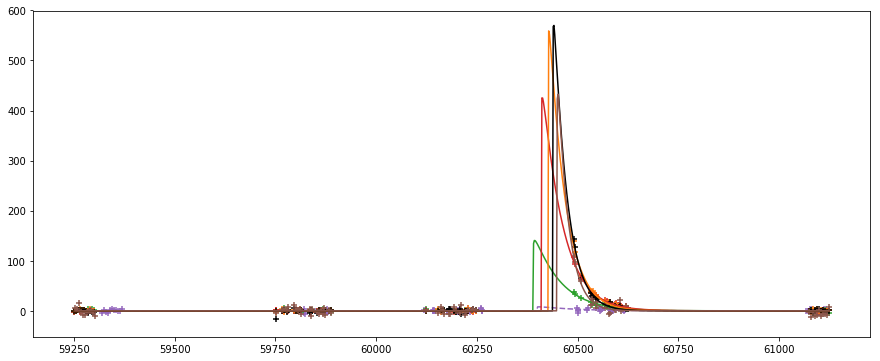

[60390.272500000036, 60409.83667666452, 60426.66387034495, 60438.87176087403]
[60390.272500000036, 60409.83667666452, 60426.66387034495, 60438.87176087403]
phi 60404.26138675238
8.00 0.05 85.08 median cov: 1
113.25 0.05 61.44 median cov: 0
426.69 0.09 47.25 median cov: 0
559.27 0.33 34.99 median cov: 0
574.40 0.71 26.69 median cov: 0
436.63 1.44 19.33 median cov: 0


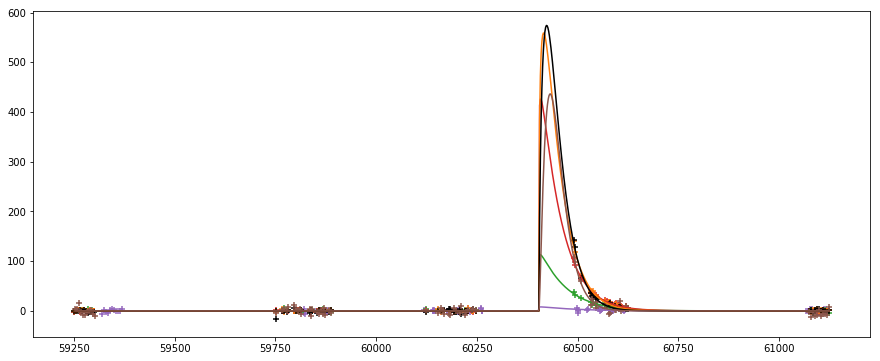

class 90 object_id =  1598
60617.0295 73 276.15957599999996 1.000499999994645
gap after
[759.4388339999998, 60612.0295, 0.5, 10]
[414.2393639999999, 60562.0295, 0.05, 1.0]
[1104.6383039999998, 60617.0295, 5.0, 100]
result: 1104.64 60607.44 2.65 12.44 median cov: 0
60624.1836 68 1448.715698 3.002599999999802
gap after
[3983.9681695, 60619.1836, 0.5, 10]
[2173.073547, 60569.1836, 0.05, 1.0]
[5794.862792, 60624.1836, 5.0, 100]
result: 2173.26 60609.48 1.08 37.24 median cov: 93
60624.176 68 1289.8514400000001 3.002599999999802
gap after
[3547.0914600000006, 60619.176, 0.5, 10]
[1934.77716, 60569.176, 0.05, 1.0]
[5159.405760000001, 60624.176, 5.0, 100]
result: 2366.65 60608.22 1.34 36.91 median cov: 0
60624.1913 68 1002.724548 3.002699999997276
gap after
[2757.492507, 60619.1913, 0.5, 10]
[1504.086822, 60569.1913, 0.05, 1.0]
[4010.898192, 60624.1913, 5.0, 100]
result: 1504.09 60608.71 0.97 45.24 median cov: 0
60624.2022 68 737.409363 3.002599999999802
gap after
[2027.87574825, 60619.2022, 0

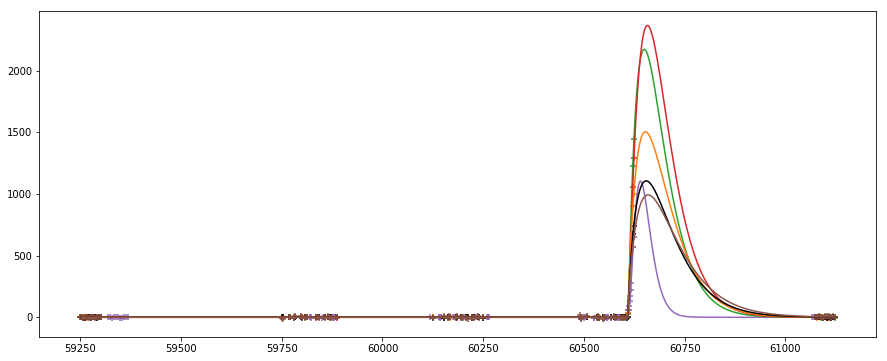

[60609.484097851346, 60608.22280397257, 60608.71043826853, 60609.03441074693]
[60609.484097851346, 60608.22280397257, 60608.71043826853, 60609.03441074693]
phi 60608.547614240146
1104.64 2.09 16.95 median cov: 0
2173.07 1.33 28.47 median cov: 0
2106.69 1.13 42.21 median cov: 0
1504.09 1.10 37.64 median cov: 0
1106.11 1.37 26.14 median cov: 0
979.57 0.83 61.95 median cov: 0


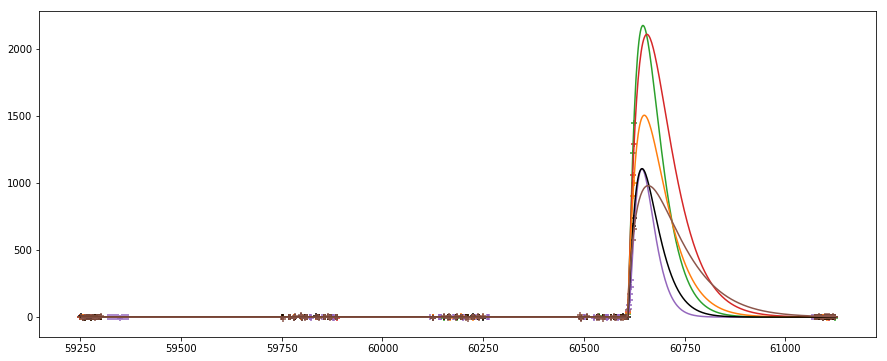

class 90 object_id =  1920
59999.1152 24 22.368911999999998 1.0054000000018277
[33.553368, 59994.1152, 0.5, 10]
[22.368911999999998, 59944.1152, 0.05, 1.0]
[44.737823999999996, 59999.1152, 5.0, 100]
result: 22.37 59983.66 5.00 3.28 median cov: 3
59991.1226 31 195.06456 2.9817000000039116
[292.59684, 59986.1226, 0.5, 10]
[195.06456, 59936.1226, 0.05, 1.0]
[390.12912, 59991.1226, 5.0, 100]
result: 202.28 59980.89 1.47 8.36 median cov: 0
59991.115 31 231.828339 2.9816999999966356
[347.7425085, 59986.115, 0.5, 10]
[231.828339, 59936.115, 0.05, 1.0]
[463.656678, 59991.115, 5.0, 100]
result: 250.02 59984.02 0.71 14.41 median cov: 0
60003.2462 32 225.627914 12.11590000000433
[338.441871, 59998.2462, 0.5, 10]
[225.627914, 59948.2462, 0.05, 1.0]
[451.255828, 60003.2462, 5.0, 100]
result: 226.13 59986.68 0.29 27.37 median cov: 0
60003.2572 32 188.361435 12.116000000001804
[282.5421525, 59998.2572, 0.5, 10]
[188.361435, 59948.2572, 0.05, 1.0]
[376.72287, 60003.2572, 5.0, 100]
result: 210.63 59991

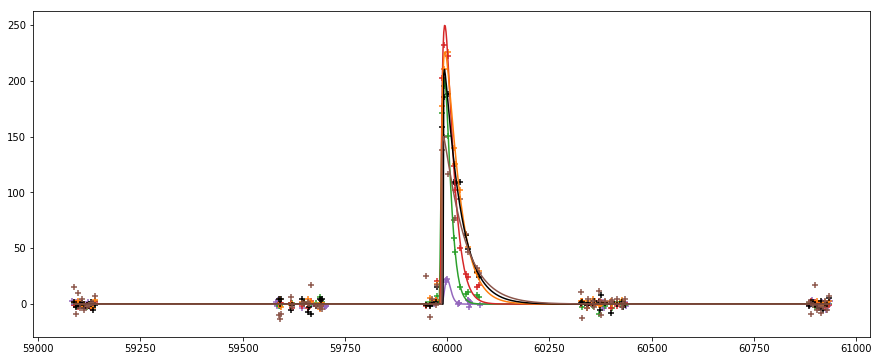

[59980.89285378341, 59984.01853246715, 59986.683580753925, 59991.087126834005]
[59980.89285378341, 59984.01853246715, 59986.683580753925, 59991.087126834005]
phi 59983.12195519697
22.37 5.00 3.38 median cov: 0
204.55 1.06 9.31 median cov: 0
248.38 0.82 13.81 median cov: 0
225.63 0.57 22.29 median cov: 0
188.36 0.41 27.75 median cov: 0
150.10 0.05 52.50 median cov: 0


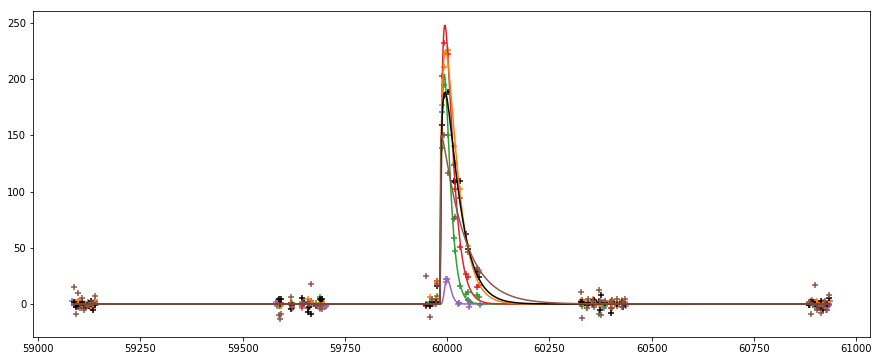

class 90 object_id =  2072
60556.0965 64 6.8506160000000005 0.9927000000025146
[10.275924, 60551.0965, 0.5, 10]
[6.8506160000000005, 60501.0965, 0.05, 1.0]
[13.701232000000001, 60556.0965, 5.0, 100]
result: 6.85 60525.18 0.11 5.80 median cov: 376049
59779.4075 12 12.795062 9.03349999999773
[19.192593, 59774.4075, 0.5, 10]
[12.795062, 59724.4075, 0.05, 1.0]
[25.590124, 59779.4075, 5.0, 100]
result: 15.24 59724.41 0.12 70.30 median cov: 20
59770.3662 11 19.92598 100.0
gap before
[54.796445, 59720.3662, 0.5, 10]
[29.88897, 59670.3662, 0.05, 1.0]
[79.70392, 59770.3662, 5.0, 100]
result: 77.00 59670.37 0.05 62.64 median cov: 34
59770.3817 11 16.612894 100.0
gap before
[45.6854585, 59720.3817, 0.5, 10]
[24.919341000000003, 59670.3817, 0.05, 1.0]
[66.451576, 59770.3817, 5.0, 100]
result: 25.56 59670.38 1.75 29.48 median cov: 77
59770.3928 11 18.105003 100.0
gap before
[49.78875825, 59720.3928, 0.5, 10]
[27.1575045, 59670.3928, 0.05, 1.0]
[72.420012, 59770.3928, 5.0, 100]
result: 72.42 59685.6

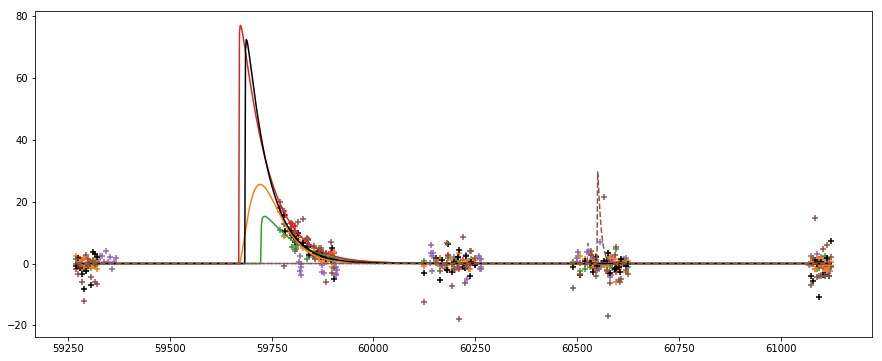

[59724.40750782477, 59670.366200024866, 59670.38170000155, 59685.646077090205]
[59724.40750782477, 59670.366200024866, 59670.38170000155, 59685.646077090205]
phi 59674.190044285366
6.85 0.11 5.80 median cov: 6017005044492300
19.87 0.37 64.36 median cov: 0
72.65 0.05 62.60 median cov: 0
25.29 1.64 29.87 median cov: 0
72.42 0.14 49.63 median cov: 0
21.65 1.53 36.19 median cov: 1


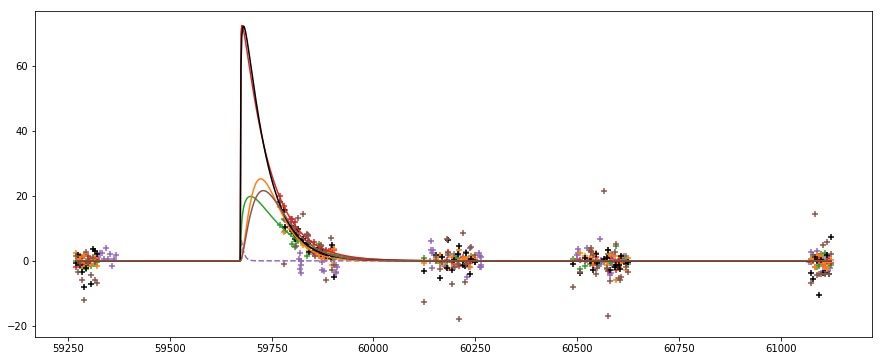

In [65]:
for class_ in [15, 42, 52, 62, 67, 90]:
    print('class', class_)
    for object_id in train[train.target==class_].object_id.unique()[:5]:
        print('class', class_, end=' ')
        plot_newling(object_id)

class 64
class 64 object_id =  62187
59368.274 10 4.336791915953543 100.0
gap before
gap after
[11.926177768872243, 59318.274, 0.5, 10]
[6.505187873930314, 59268.274, 0.05, 1.0]
[17.347167663814172, 59368.274, 5.0, 100]
result: 7.42 59281.30 0.10 2.06 median cov: 203349894007477216
61112.1365 65 5.26645933174516 100.0
gap before
gap after
[14.48276316229919, 61062.1365, 0.5, 10]
[7.899688997617739, 61012.1365, 0.05, 1.0]
[21.06583732698064, 61112.1365, 5.0, 100]
result: 7.90 61012.47 1.15 14.70 median cov: 504799
60580.1736 51 24.257456 12.844499999999243
[36.386184, 60575.1736, 0.5, 10]
[24.257456, 60525.1736, 0.05, 1.0]
[48.514912, 60580.1736, 5.0, 100]
result: 37.35 60566.80 2.35 3.28 median cov: 7


/home/jfpuget/anaconda3/envs/tf110/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in sqrt
/home/jfpuget/anaconda3/envs/tf110/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in power


60580.1889 51 36.89312 12.844499999999243
[55.33968, 60575.1889, 0.5, 10]
[36.89312, 60525.1889, 0.05, 1.0]
[73.78624, 60580.1889, 5.0, 100]
result: 58.10 60575.42 2.85 1.00 median cov: 30233974335816
60580.1999 50 21.121261999999998 12.844599999996717
[31.681892999999995, 60575.1999, 0.5, 10]
[21.121261999999998, 60525.1999, 0.05, 1.0]
[42.242523999999996, 60580.1999, 5.0, 100]
result: 42.05 60576.13 5.00 1.45 median cov: 18202
59887.3228 21 13.117294000000001 3.109600000003411
[19.675941, 59882.3228, 0.5, 10]
[13.117294000000001, 59832.3228, 0.05, 1.0]
[26.234588000000002, 59887.3228, 5.0, 100]
result: 16.25 59884.21 0.72 4.58 median cov: 311


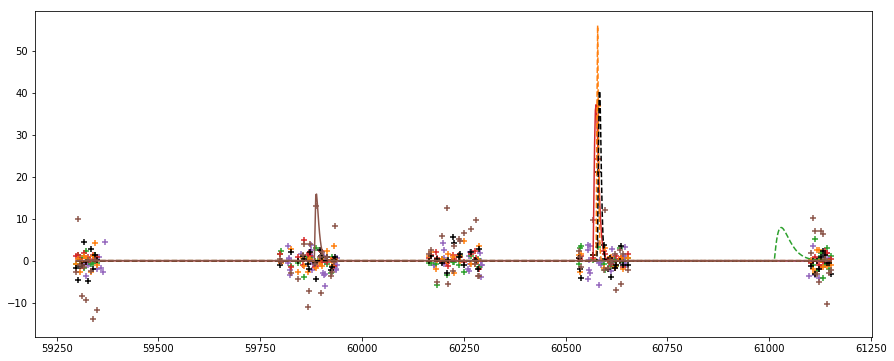

[60566.79746058331]
class 64 object_id =  139362
59092.3282 2 3.957299844593975 100.0
gap before
gap after
[10.88257457263343, 59042.3282, 0.5, 10]
[5.935949766890962, 58992.3282, 0.05, 1.0]
[15.8291993783759, 59092.3282, 5.0, 100]
result: 6.17 58994.78 0.08 1.83 median cov: 0
59688.0047 22 6.683827000000001 8.98979999999574
[10.025740500000001, 59683.0047, 0.5, 10]
[6.683827000000001, 59633.0047, 0.05, 1.0]
[13.367654000000002, 59688.0047, 5.0, 100]
result: 7.80 59666.03 0.06 6.32 median cov: 80615
60016.0879 33 26.878651 12.85689999999886
[40.3179765, 60011.0879, 0.5, 10]
[26.878651, 59961.0879, 0.05, 1.0]
[53.757302, 60016.0879, 5.0, 100]
result: 41.16 60003.23 1.95 3.63 median cov: 0
60016.1032 33 44.678298999999996 12.856999999996333
[67.0174485, 60011.1032, 0.5, 10]
[44.678298999999996, 59961.1032, 0.05, 1.0]
[89.35659799999999, 60016.1032, 5.0, 100]
result: 67.86 60002.11 3.52 2.53 median cov: 0
60016.1141 33 13.835822 12.85689999999886
[20.753733, 60011.1141, 0.5, 10]
[13.83582

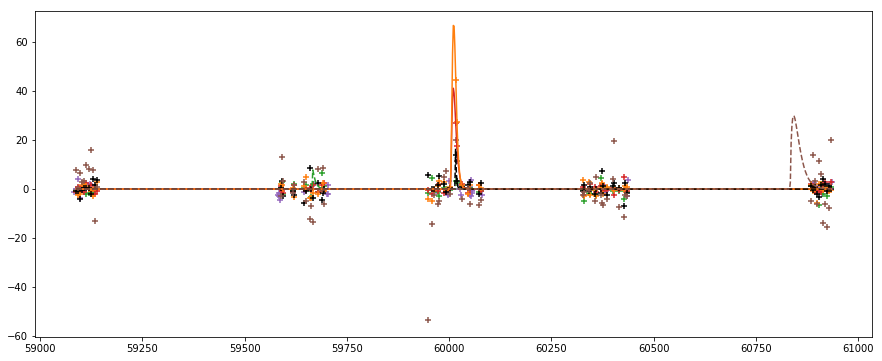

[60003.229134697474, 60002.11300762268]
phi 60002.39203939137
5.94 0.05 1.00 median cov: 0
6.68 0.05 14.11 median cov: 0
34.83 3.18 2.94 median cov: 0
70.88 3.10 2.68 median cov: 0
13.84 0.05 1.00 median cov: 157118389201
34.25 5.00 1.79 median cov: 19


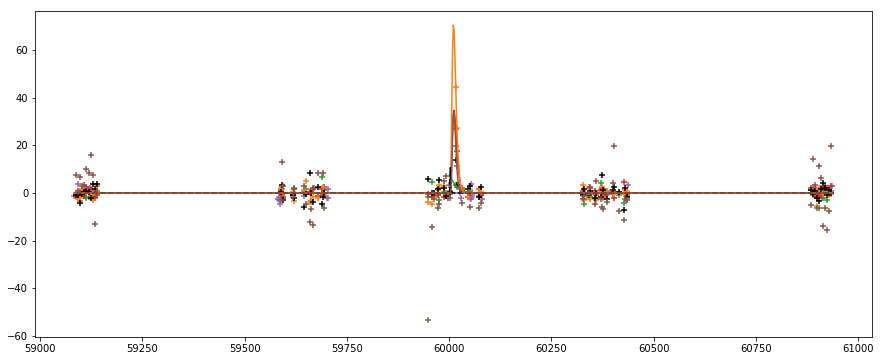

class 64 object_id =  1573501
61126.1215 27 335.9010017597153 100.0
gap before
gap after
[923.7277548392171, 61076.1215, 0.5, 10]
[503.85150263957297, 61026.1215, 0.05, 1.0]
[1343.6040070388613, 61126.1215, 5.0, 100]
result: 503.85 61026.12 5.00 9.87 median cov: 12019
61159.1531 28 42.21623859538105 100.0
gap before
gap after
[116.09465613729789, 61109.1531, 0.5, 10]
[63.32435789307158, 61059.1531, 0.05, 1.0]
[168.8649543815242, 61159.1531, 5.0, 100]
result: 67.94 61063.58 0.09 1.84 median cov: 0
60616.2673 30 164.10514799999999 26.925799999997253
[246.15772199999998, 60611.2673, 0.5, 10]
[164.10514799999999, 60561.2673, 0.05, 1.0]
[328.21029599999997, 60616.2673, 5.0, 100]
result: 252.47 60613.08 0.05 5.26 median cov: 3
60064.076 25 87.724426 22.01520000000164
[131.586639, 60059.076, 0.5, 10]
[87.724426, 60009.076, 0.05, 1.0]
[175.448852, 60064.076, 5.0, 100]
result: 175.45 60063.19 0.05 1.00 median cov: 0
60601.3756 36 739.345215 21.987300000000687
[1109.0178225, 60596.3756, 0.5, 10]

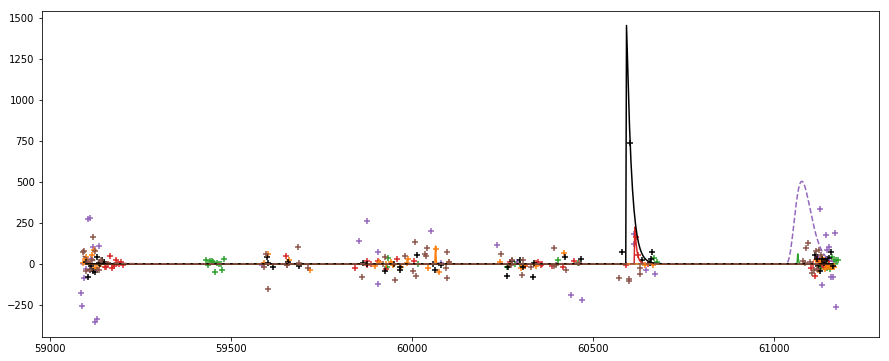

[61063.58349593436, 60613.080528657185, 60063.18870655574, 60589.97174539829]
phi 60332.357421791734
503.85 0.25 1.35 median cov: 0
67.94 0.09 1.84 median cov: 0
164.11 0.05 2.29 median cov: 46654
87.72 0.05 1.00 median cov: 0
739.35 0.05 1.00 median cov: 0
662.06 5.00 4.97 median cov: 1659


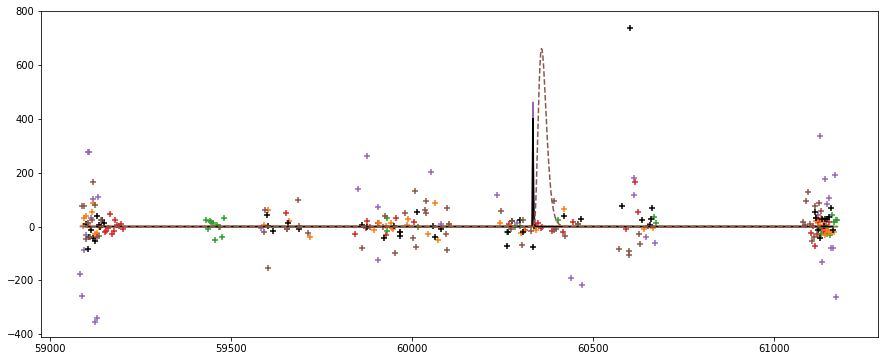

class 64 object_id =  3572446
60437.0804 20 11.356278999999999 53.872199999997974
gap before
[31.229767249999995, 60387.0804, 0.5, 10]
[17.034418499999997, 60337.0804, 0.05, 1.0]
[45.425115999999996, 60437.0804, 5.0, 100]
result: 39.80 60425.30 4.64 1.32 median cov: 1019479406849213
60487.99 19 42.954063 26.901099999995495
[64.4310945, 60482.99, 0.5, 10]
[42.954063, 60432.99, 0.05, 1.0]
[85.908126, 60487.99, 5.0, 100]
result: 62.27 60479.06 1.95 2.61 median cov: 0
60492.0678 26 142.39505 33.97179999999935
gap after
[391.5863875, 60487.0678, 0.5, 10]
[213.592575, 60437.0678, 0.05, 1.0]
[569.5802, 60492.0678, 5.0, 100]
result: 268.94 60487.25 1.30 12.15 median cov: 0
60485.0349 29 692.9979860000001 25.860099999998056
gap after
[1905.7444615000002, 60480.0349, 0.5, 10]
[1039.496979, 60430.0349, 0.05, 1.0]
[2771.9919440000003, 60485.0349, 5.0, 100]
result: 1507.73 60463.07 2.70 19.41 median cov: 35165435343200
59182.4019 8 22.875040292063865 100.0
gap before
gap after
[62.90636080317563, 5

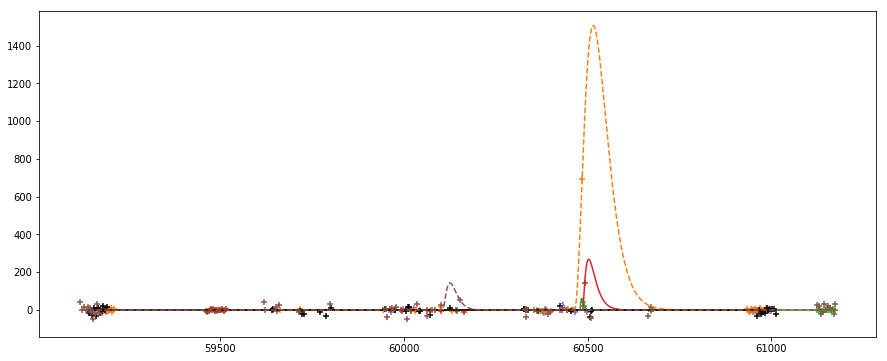

[60479.05697692959, 60487.250147574836, 59093.210650353554]
phi 59786.13381364157
39.80 4.64 1.32 median cov: 0
62.27 1.95 2.61 median cov: 0
569.58 5.00 10.63 median cov: 327060
1443.52 4.31 9.25 median cov: 612971744535
34.31 0.05 1.00 median cov: 2557
98.84 5.00 5.88 median cov: 2734606321773


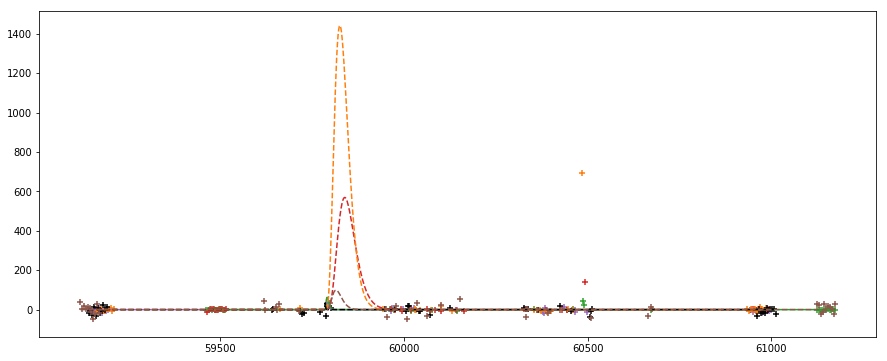

class 64 object_id =  4311960
60983.9952 30 21.502215052497128 100.0
gap before
gap after
[59.131091394367104, 60933.9952, 0.5, 10]
[32.253322578745696, 60883.9952, 0.05, 1.0]
[86.00886020998851, 60983.9952, 5.0, 100]
result: 43.17 60928.55 5.00 1.62 median cov: 1013447634
59807.0006 13 8.175367999999999 16.9574999999968
gap after
[22.482262, 59802.0006, 0.5, 10]
[12.263051999999998, 59752.0006, 0.05, 1.0]
[32.701471999999995, 59807.0006, 5.0, 100]
result: 17.13 59800.52 2.33 6.95 median cov: 160993191398446989312
60018.3873 16 28.714465999999998 16.136200000000827
[43.071698999999995, 60013.3873, 0.5, 10]
[28.714465999999998, 59963.3873, 0.05, 1.0]
[57.428931999999996, 60018.3873, 5.0, 100]
result: 39.68 60009.85 2.53 2.11 median cov: 32421959308204532
59212.369 10 13.16887144424872 100.0
gap before
gap after
[36.21439647168398, 59162.369, 0.5, 10]
[19.75330716637308, 59112.369, 0.05, 1.0]
[52.67548577699488, 59212.369, 5.0, 100]
result: 19.75 59112.37 0.05 31.67 median cov: 80512
600

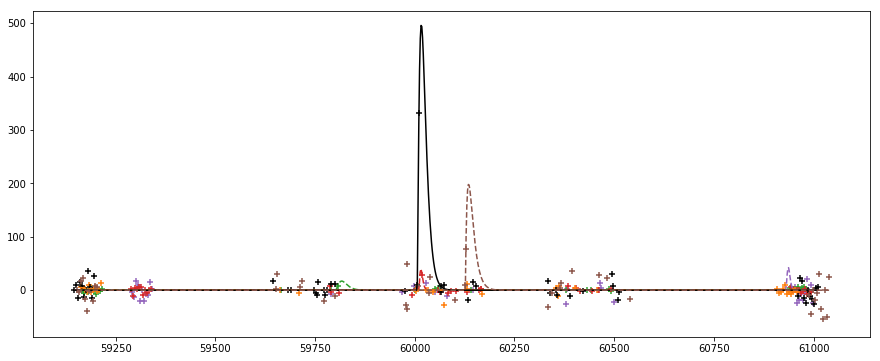

[60006.01636542509]
class 88
class 88 object_id =  713
59905.0468 20 14.509829000000002 0.9883999999947264
[21.7647435, 59900.0468, 0.5, 10]
[14.509829000000002, 59850.0468, 0.05, 1.0]
[29.019658000000003, 59905.0468, 5.0, 100]
result: 15.83 59880.12 0.10 25.31 median cov: 35136
59916.0621 25 9.129021 2.809900000000198
[13.693531499999999, 59911.0621, 0.5, 10]
[9.129021, 59861.0621, 0.05, 1.0]
[18.258042, 59916.0621, 5.0, 100]
result: 9.13 59904.08 3.79 3.65 median cov: 18
59916.0544 25 10.529041000000001 2.809800000002724
[15.793561500000003, 59911.0544, 0.5, 10]
[10.529041000000001, 59861.0544, 0.05, 1.0]
[21.058082000000002, 59916.0544, 5.0, 100]
result: 10.53 59912.38 0.80 5.39 median cov: 1
59902.0598 23 11.330316 2.959100000000035
[16.995474, 59897.0598, 0.5, 10]
[11.330316, 59847.0598, 0.05, 1.0]
[22.660632, 59902.0598, 5.0, 100]
result: 11.33 59899.09 0.23 19.05 median cov: 0
59916.0806 25 9.827933999999999 2.809800000002724
[14.741900999999999, 59911.0806, 0.5, 10]
[9.82793399

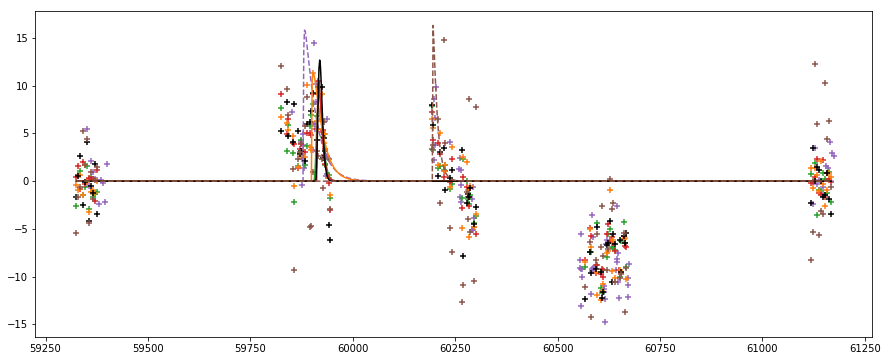

[59904.08204720847, 59912.38167951741, 59899.09374469448, 59907.814284906766]
phi 59902.52095537605
14.51 0.05 7.02 median cov: 0
9.13 4.62 3.35 median cov: 1
10.53 0.13 15.34 median cov: 2
11.33 0.10 21.12 median cov: 1
9.83 5.00 3.16 median cov: 1
14.77 0.05 9.75 median cov: 22


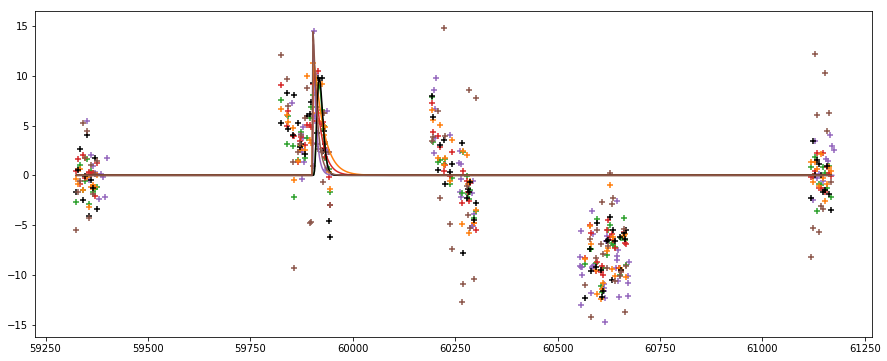

class 88 object_id =  3489
59582.3282 11 17.009882 100.0
gap before
[46.7771755, 59532.3282, 0.5, 10]
[25.514823, 59482.3282, 0.05, 1.0]
[68.039528, 59582.3282, 5.0, 100]
result: 68.04 59576.92 0.05 3.02 median cov: 1994
59618.2024 14 12.235389999999999 23.930400000004738
[18.353085, 59613.2024, 0.5, 10]
[12.235389999999999, 59563.2024, 0.05, 1.0]
[24.470779999999998, 59618.2024, 5.0, 100]
result: 14.36 59590.87 0.32 31.53 median cov: 0
59687.9971 22 9.781057 8.989800000003015
[14.6715855, 59682.9971, 0.5, 10]
[9.781057, 59632.9971, 0.05, 1.0]
[19.562114, 59687.9971, 5.0, 100]
result: 9.81 59663.01 0.12 20.73 median cov: 0
59588.2343 11 9.618625999999999 100.0
gap before
[26.451221499999996, 59538.2343, 0.5, 10]
[14.427938999999999, 59488.2343, 0.05, 1.0]
[38.474503999999996, 59588.2343, 5.0, 100]
result: 14.43 59488.23 0.70 53.78 median cov: 11121
59621.1553 15 9.753960000000001 2.9343000000008033
[14.630940000000002, 59616.1553, 0.5, 10]
[9.753960000000001, 59566.1553, 0.05, 1.0]
[19

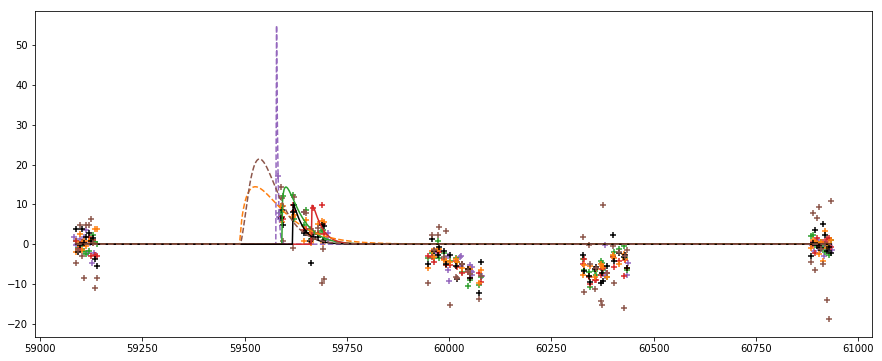

[59590.87251278236, 59663.014641917296, 59618.20822828398]
phi 59604.54037053317
25.51 0.05 31.18 median cov: 37
14.37 0.05 36.91 median cov: 0
10.18 0.05 56.86 median cov: 0
14.43 0.05 27.91 median cov: 1
11.67 0.05 31.29 median cov: 1
21.40 5.00 5.48 median cov: 2


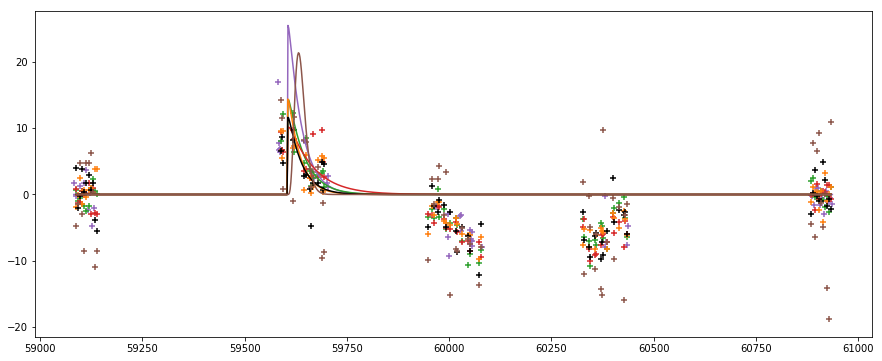

class 88 object_id =  4088
61095.1257 88 4.955697203030859 100.0
gap before
gap after
[13.628167308334861, 61045.1257, 0.5, 10]
[7.433545804546288, 60995.1257, 0.05, 1.0]
[19.822788812123434, 61095.1257, 5.0, 100]
result: 9.77 61013.28 0.21 3.44 median cov: 636215342711836672
59295.374 5 3.3560100340068413 100.0
gap before
gap after
[9.229027593518813, 59245.374, 0.5, 10]
[5.034015051010262, 59195.374, 0.05, 1.0]
[13.424040136027365, 59295.374, 5.0, 100]
result: 5.03 59195.37 0.05 37.03 median cov: 8466958496
61079.0348 68 3.065686845986148 100.0
gap before
gap after
[8.430638826461907, 61029.0348, 0.5, 10]
[4.598530268979222, 60979.0348, 0.05, 1.0]
[12.262747383944593, 61079.0348, 5.0, 100]
result: 4.72 60980.61 0.11 27.99 median cov: 100091496945
59300.3817 6 3.7101221535519473 100.0
gap before
gap after
[10.202835922267855, 59250.3817, 0.5, 10]
[5.565183230327921, 59200.3817, 0.05, 1.0]
[14.84048861420779, 59300.3817, 5.0, 100]
result: 6.53 59210.40 0.09 1.80 median cov: 0
59285.392

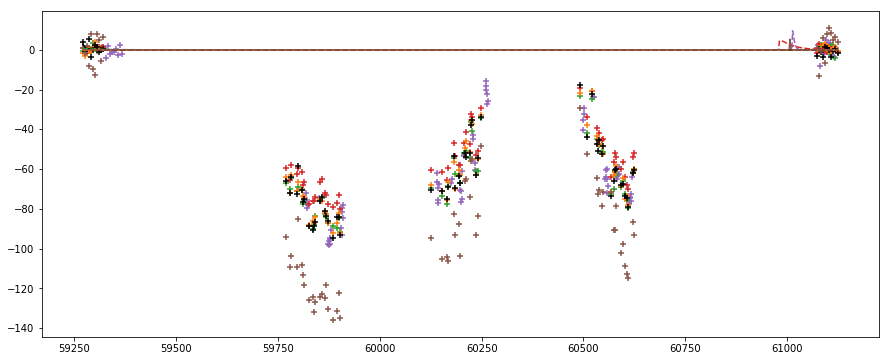

[59210.39713074563]
class 88 object_id =  7315
60499.2579 56 1186.7071529999998 234.21919999999955
gap before
[3263.4446707499997, 60449.2579, 0.5, 10]
[1780.0607294999998, 60399.2579, 0.05, 1.0]
[4746.828611999999, 60499.2579, 5.0, 100]
result: 1780.06 60399.26 5.00 15.91 median cov: 2
60491.3523 48 1243.337524 242.2632999999987
gap before
[3419.178191, 60441.3523, 0.5, 10]
[1865.006286, 60391.3523, 0.05, 1.0]
[4973.350096, 60491.3523, 5.0, 100]
result: 1865.01 60391.35 4.53 17.45 median cov: 1
60491.3446 48 1383.304443 242.2632999999987
gap before
[3804.0872182499998, 60441.3446, 0.5, 10]
[2074.9566645, 60391.3446, 0.05, 1.0]
[5533.217772, 60491.3446, 5.0, 100]
result: 2074.96 60391.34 4.85 16.71 median cov: 0
60491.36 48 1930.695312 242.26340000000346
gap before
[5309.412108, 60441.36, 0.5, 10]
[2896.042968, 60391.36, 0.05, 1.0]
[7722.781248, 60491.36, 5.0, 100]
result: 2896.04 60391.36 4.75 16.98 median cov: 0
60491.3711 48 1846.404175 242.26349999999366
gap before
[5077.61148125, 

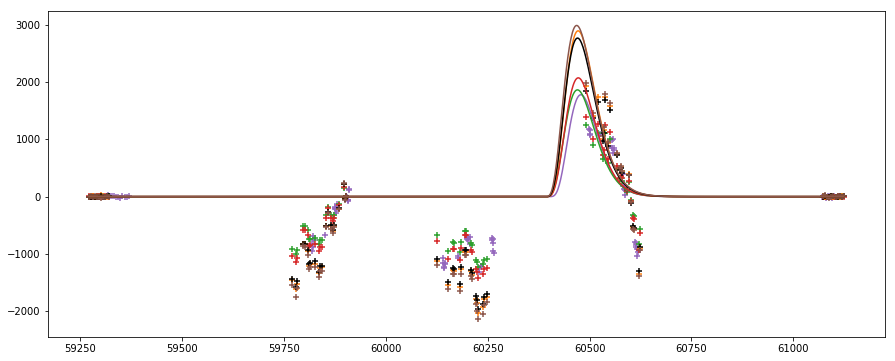

[60391.3523000249, 60391.34460000041, 60391.360000439745, 60391.37110000009]
phi 60391.350375116366
1780.06 5.00 16.68 median cov: 0
1865.01 4.53 17.44 median cov: 0
2074.96 4.85 16.71 median cov: 0
2896.04 4.75 16.98 median cov: 0
2769.61 4.55 17.41 median cov: 0
2990.34 4.22 18.27 median cov: 0


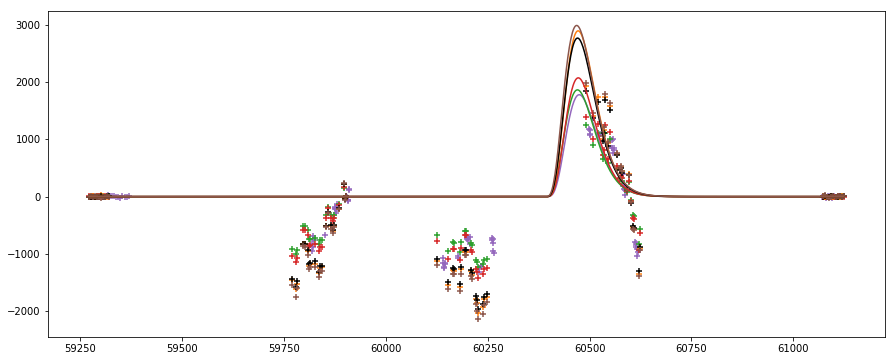

class 88 object_id =  7409
59874.0599 17 7.082586 22.948499999998603
[10.623879, 59869.0599, 0.5, 10]
[7.082586, 59819.0599, 0.05, 1.0]
[14.165172, 59874.0599, 5.0, 100]
result: 14.17 59870.13 0.05 3.75 median cov: 37
59779.3265 15 18.855591 9.100900000004913
[28.2833865, 59774.3265, 0.5, 10]
[18.855591, 59724.3265, 0.05, 1.0]
[37.711182, 59779.3265, 5.0, 100]
result: 18.86 59767.30 0.05 83.74 median cov: 0
59782.1897 16 23.62244 2.8709000000017113
[35.43366, 59777.1897, 0.5, 10]
[23.62244, 59727.1897, 0.05, 1.0]
[47.24488, 59782.1897, 5.0, 100]
result: 23.62 59763.28 0.18 79.85 median cov: 5
59782.2051 16 25.217247 2.8709000000017113
[37.8258705, 59777.2051, 0.5, 10]
[25.217247, 59727.2051, 0.05, 1.0]
[50.434494, 59782.2051, 5.0, 100]
result: 25.22 59727.21 0.39 77.44 median cov: 4
59750.445 11 34.641533 100.0
gap before
[95.26421575, 59700.445, 0.5, 10]
[51.9622995, 59650.445, 0.05, 1.0]
[138.566132, 59750.445, 5.0, 100]
result: 51.96 59650.45 0.13 100.00 median cov: 68
59779.3562 14

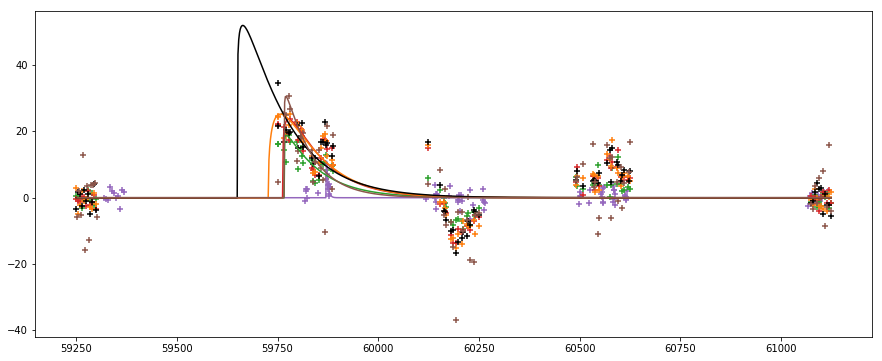

[59767.29729781157, 59763.284526374155, 59727.205100002546, 59650.445000000254]
phi 59697.8449065943
14.17 0.05 3.75 median cov: 0
18.86 0.48 78.48 median cov: 0
23.62 0.90 65.39 median cov: 0
25.22 0.70 71.54 median cov: 0
51.96 0.05 86.02 median cov: 0
30.58 0.33 78.30 median cov: 0


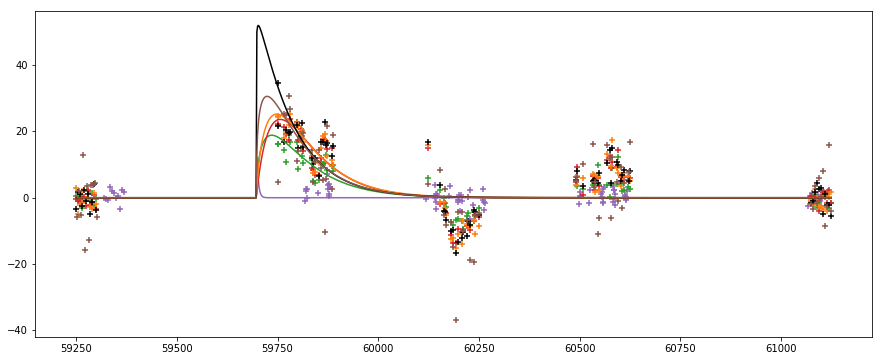

class 95
class 95 object_id =  3423
60560.1065 60 7.71422 0.9968000000008033
[11.57133, 60555.1065, 0.5, 10]
[7.71422, 60505.1065, 0.05, 1.0]
[15.42844, 60560.1065, 5.0, 100]
result: 7.84 60559.37 0.73 1.26 median cov: 30361582585476
59800.3244 18 6.21014 3.0305999999982305
[9.31521, 59795.3244, 0.5, 10]
[6.21014, 59745.3244, 0.05, 1.0]
[12.42028, 59800.3244, 5.0, 100]
result: 7.69 59797.29 0.30 6.12 median cov: 102
60124.2541 33 7.741397 237.22430000000168
gap before
[21.28884175, 60074.2541, 0.5, 10]
[11.6120955, 60024.2541, 0.05, 1.0]
[30.965588, 60124.2541, 5.0, 100]
result: 30.97 60061.48 0.05 35.95 median cov: 1664
60124.2695 33 22.242645 237.22439999999915
gap before
[61.16727375, 60074.2695, 0.5, 10]
[33.3639675, 60024.2695, 0.05, 1.0]
[88.97058, 60124.2695, 5.0, 100]
result: 88.97 60038.24 0.05 50.98 median cov: 169
60124.2807 33 39.706257 237.2245000000039
gap before
[109.19220675, 60074.2807, 0.5, 10]
[59.559385500000005, 60024.2807, 0.05, 1.0]
[158.825028, 60124.2807, 5.0, 

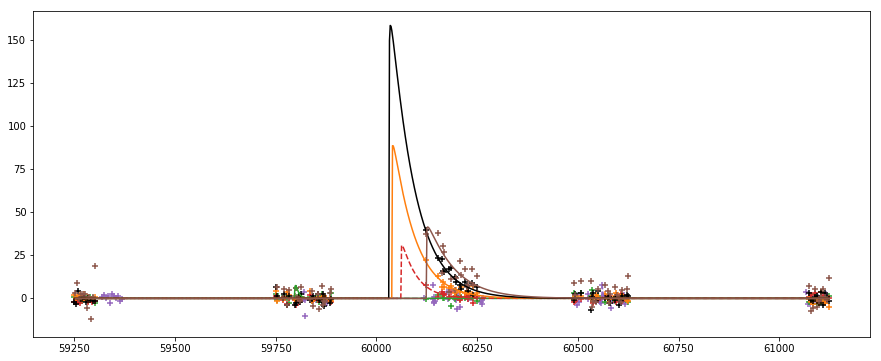

[59797.29454821058, 60038.24333133662, 60032.21471314125]
phi 59914.75463067592
7.84 0.73 1.26 median cov: 0
7.69 0.30 6.12 median cov: 0
30.97 4.62 21.94 median cov: 18
88.97 2.09 36.89 median cov: 1
158.83 1.81 40.87 median cov: 1
75.58 2.24 47.59 median cov: 2


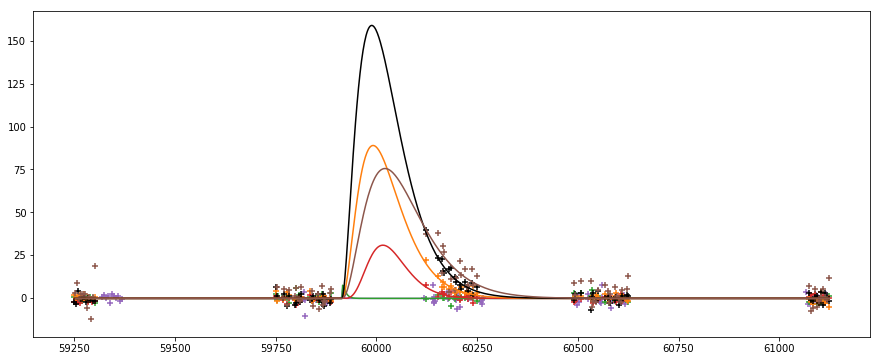

class 95 object_id =  10321
60560.1152 68 108.10068500000001 0.996899999998277
[162.15102750000003, 60555.1152, 0.5, 10]
[108.10068500000001, 60505.1152, 0.05, 1.0]
[216.20137000000003, 60560.1152, 5.0, 100]
result: 109.12 60505.12 2.40 25.79 median cov: 0
60577.0738 58 210.599579 2.8900999999968917
[315.89936850000004, 60572.0738, 0.5, 10]
[210.599579, 60522.0738, 0.05, 1.0]
[421.199158, 60577.0738, 5.0, 100]
result: 210.60 60522.07 1.10 49.87 median cov: 0
60596.0872 61 330.83547999999996 3.0714000000007218
[496.25321999999994, 60591.0872, 0.5, 10]
[330.83547999999996, 60541.0872, 0.05, 1.0]
[661.6709599999999, 60596.0872, 5.0, 100]
result: 330.84 60541.09 0.50 89.61 median cov: 0
60603.0839 62 365.325134 6.981199999994715
[547.987701, 60598.0839, 0.5, 10]
[365.325134, 60548.0839, 0.05, 1.0]
[730.650268, 60603.0839, 5.0, 100]
result: 365.33 60548.08 0.35 100.00 median cov: 0
60609.0987 64 364.413727 3.0020000000004075
[546.6205904999999, 60604.0987, 0.5, 10]
[364.413727, 60554.0987, 

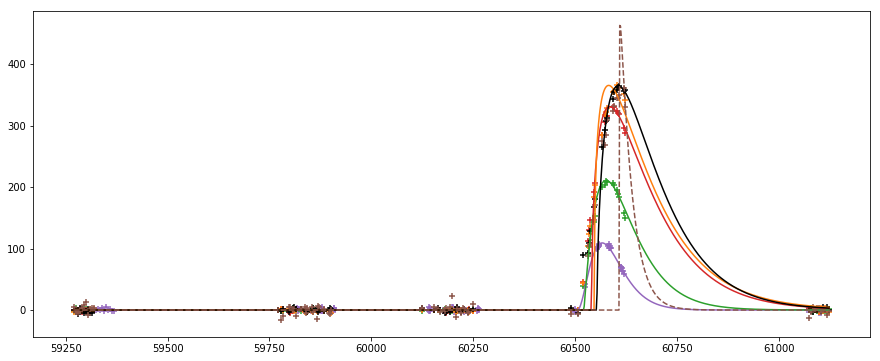

[60522.07380000412, 60541.08720000001, 60548.08390021599, 60554.09870000511]
phi 60533.329675056055
112.46 1.14 31.28 median cov: 0
210.60 0.60 68.88 median cov: 0
330.84 0.63 89.55 median cov: 0
365.33 0.71 95.48 median cov: 0
364.41 0.77 100.00 median cov: 0
360.33 0.85 98.94 median cov: 0


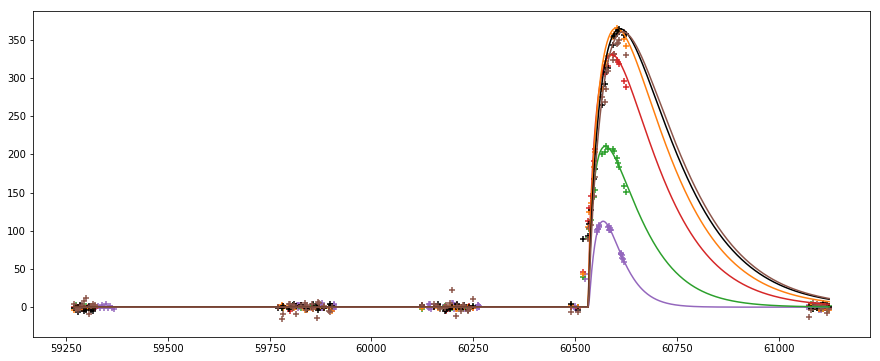

class 95 object_id =  14553
60620.1257 82 200.889099 3.0872999999992317
gap after
[552.44502225, 60615.1257, 0.5, 10]
[301.3336485, 60565.1257, 0.05, 1.0]
[803.556396, 60620.1257, 5.0, 100]
result: 301.33 60567.07 1.95 51.25 median cov: 0
60624.0425 66 249.497421 2.814700000002631
gap after
[686.11790775, 60619.0425, 0.5, 10]
[374.2461315, 60569.0425, 0.05, 1.0]
[997.989684, 60624.0425, 5.0, 100]
result: 374.25 60576.22 1.47 62.57 median cov: 0
60624.0348 66 310.562775 2.8145999999978812
gap after
[854.04763125, 60619.0348, 0.5, 10]
[465.8441625, 60569.0348, 0.05, 1.0]
[1242.2511, 60624.0348, 5.0, 100]
result: 465.84 60575.46 1.63 57.90 median cov: 0
60624.0502 66 286.72805800000003 2.814699999995355
gap after
[788.5021595000001, 60619.0502, 0.5, 10]
[430.09208700000005, 60569.0502, 0.05, 1.0]
[1146.9122320000001, 60624.0502, 5.0, 100]
result: 430.09 60574.48 1.74 56.03 median cov: 0
60624.0612 66 257.29614300000003 2.814799999992829
gap after
[707.5643932500001, 60619.0612, 0.5, 10]
[

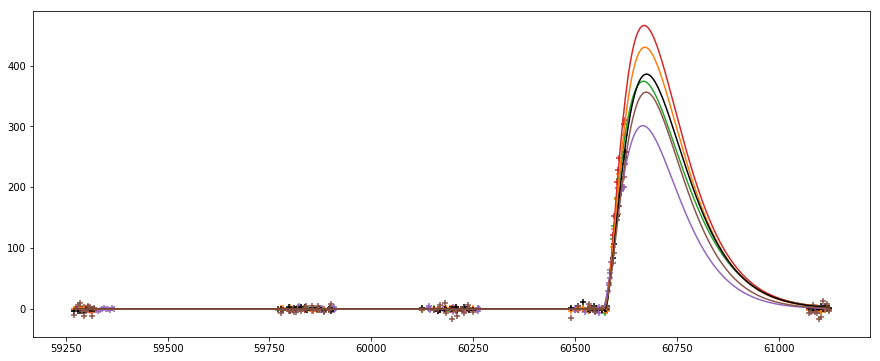

[60576.21890394796, 60575.4649950391, 60574.48258617244, 60573.45559710078]
phi 60574.214693853275
301.33 1.45 65.57 median cov: 0
374.25 1.59 59.22 median cov: 0
465.84 1.71 56.08 median cov: 0
430.09 1.76 55.65 median cov: 0
385.94 1.76 57.66 median cov: 0
356.35 1.80 56.10 median cov: 0


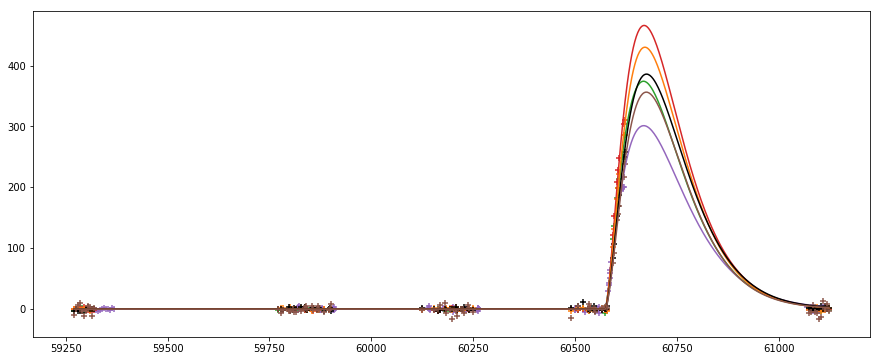

class 95 object_id =  23539
60582.1681 62 1195.25647 21.941300000005867
[1792.884705, 60577.1681, 0.5, 10]
[1195.25647, 60527.1681, 0.05, 1.0]
[2390.51294, 60582.1681, 5.0, 100]
result: 1226.54 60538.91 1.88 18.37 median cov: 0
60580.1813 51 1585.4179689999999 12.844499999999243
[2378.1269534999997, 60575.1813, 0.5, 10]
[1585.4179689999999, 60525.1813, 0.05, 1.0]
[3170.8359379999997, 60580.1813, 5.0, 100]
result: 1595.02 60567.38 0.43 35.89 median cov: 1
60593.1209 52 1549.000977 12.947299999999814
[2323.5014655, 60588.1209, 0.5, 10]
[1549.000977, 60538.1209, 0.05, 1.0]
[3098.001954, 60593.1209, 5.0, 100]
result: 1553.16 60552.40 0.80 42.81 median cov: 0
60593.1365 52 1437.070923 12.947599999999511
[2155.6063845, 60588.1365, 0.5, 10]
[1437.070923, 60538.1365, 0.05, 1.0]
[2874.141846, 60593.1365, 5.0, 100]
result: 1437.07 60554.19 0.71 56.55 median cov: 0
60605.1174 53 1325.567505 8.956100000003062
[1988.3512575, 60600.1174, 0.5, 10]
[1325.567505, 60550.1174, 0.05, 1.0]
[2651.13501, 606

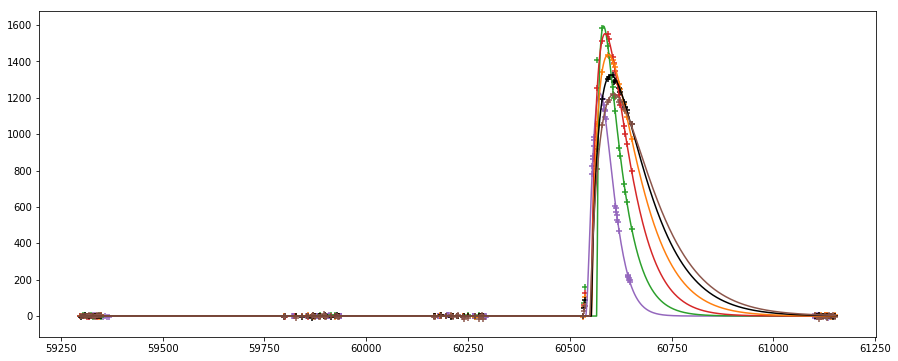

[60567.38097954246, 60552.397805666544, 60554.18999901188, 60553.43201700417]
phi 60553.10440683729
1322.41 0.55 27.80 median cov: 0
1606.20 0.85 30.98 median cov: -0
1554.89 0.77 43.46 median cov: 0
1437.07 0.75 54.77 median cov: 0
1325.57 0.72 66.21 median cov: 0
1219.61 0.71 76.84 median cov: 0


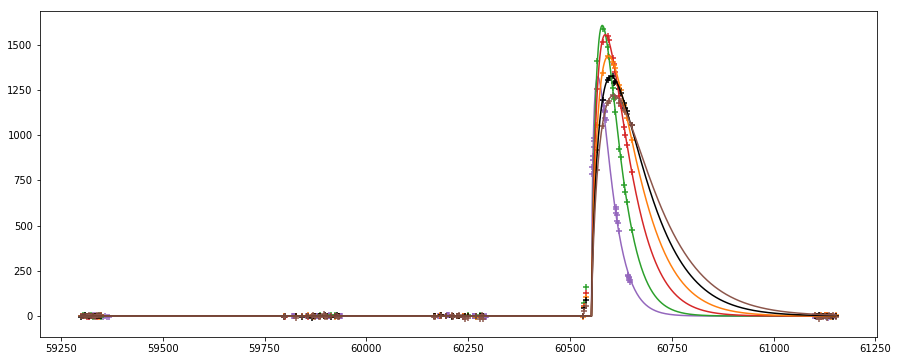

class 95 object_id =  31569
59820.1047 12 215.64447 0.9515000000028522
[323.46670500000005, 59815.1047, 0.5, 10]
[215.64447, 59765.1047, 0.05, 1.0]
[431.28894, 59820.1047, 5.0, 100]
result: 215.64 59812.68 0.42 15.23 median cov: 0
59813.1122 21 297.759125 3.0
[446.63868749999995, 59808.1122, 0.5, 10]
[297.759125, 59758.1122, 0.05, 1.0]
[595.51825, 59813.1122, 5.0, 100]
result: 297.76 59773.44 3.21 12.65 median cov: 0
59813.1044 21 341.588257 2.9998999999952503
[512.3823855, 59808.1044, 0.5, 10]
[341.588257, 59758.1044, 0.05, 1.0]
[683.176514, 59813.1044, 5.0, 100]
result: 344.50 59774.44 2.74 16.19 median cov: 0
59813.1199 21 297.326355 2.9998999999952503
[445.9895325, 59808.1199, 0.5, 10]
[297.326355, 59758.1199, 0.05, 1.0]
[594.65271, 59813.1199, 5.0, 100]
result: 311.64 59782.24 1.71 23.02 median cov: 0
59835.0866 22 265.006622 21.95560000000114
[397.509933, 59830.0866, 0.5, 10]
[265.006622, 59780.0866, 0.05, 1.0]
[530.013244, 59835.0866, 5.0, 100]
result: 332.70 59813.12 0.05 61.48

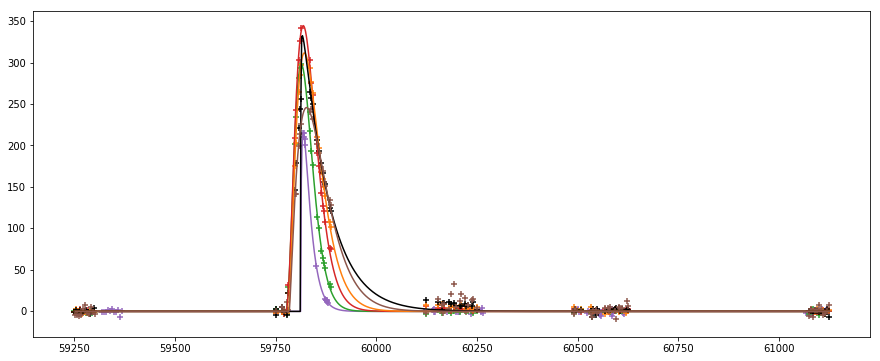

[59773.44495515396, 59774.437689976934, 59782.241354675796, 59813.12480817886]
phi 59775.89223874016
248.37 3.26 10.20 median cov: 0
297.76 2.80 13.46 median cov: 0
344.18 2.54 16.78 median cov: 0
310.56 2.32 20.09 median cov: 0
271.57 2.08 24.03 median cov: 0
245.88 1.99 26.46 median cov: 0


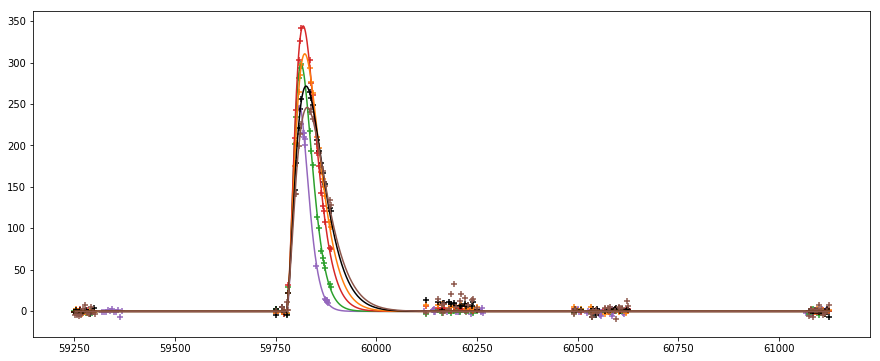

In [54]:
for class_ in [64, 88, 95]:
    print('class', class_)
    for object_id in train[train.target==class_].object_id.unique()[:5]:
        print('class', class_, end=' ')
        plot_newling(object_id)